In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import esda as es
import json
import libpysal as ps
from esda.moran import Moran
import geopandas as gpd
from shapely.geometry import Point

## Load data

In [2]:
plt.style.use('ggplot')
# load the feature category dictionary
with open('feature_category_dict.json') as f:
	fcmap = json.load(f)

data=pd.read_csv('combined_data_with_loc.csv')
data.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947


## Visualize Suburbs

$(x,y)$ locations based on the compass bearing and the distance from Melbourne GPO, with GPO co-ordinate as $(0,0)$

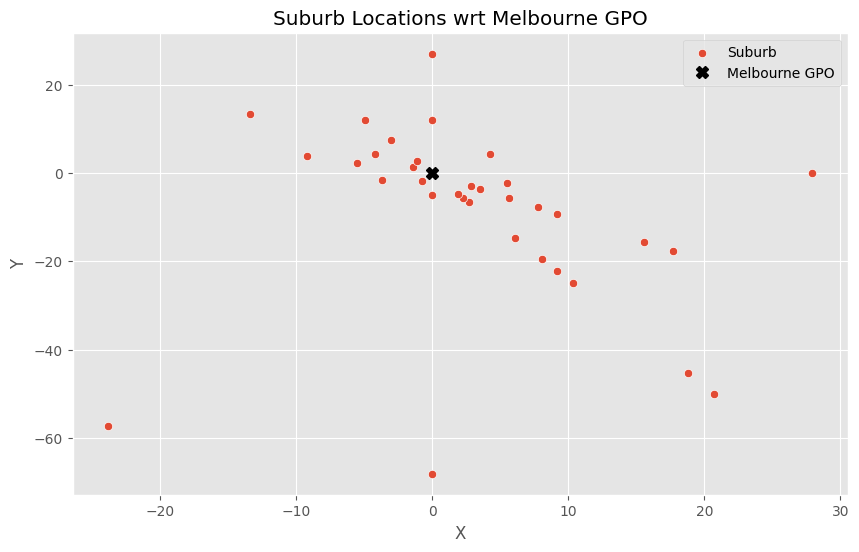

In [3]:
# plot boxes around the points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cart_x', y='cart_y', data=data)
plt.xlabel('X')
plt.ylabel('Y')
# show origin
plt.plot(0, 0, 'X', markersize=9, color='black')
plt.legend(['Suburb', 'Melbourne GPO'])
plt.title('Suburb Locations wrt Melbourne GPO')
plt.show()

## Avg distances of the neighbouring suburbs

In [4]:
from sklearn.neighbors import NearestNeighbors
import scipy.stats as stats

class nnStats:
	def __init__(self, n_nbd):
		self.n_nbd=n_nbd
	def get_dist_mean(self):
		nn=NearestNeighbors(n_neighbors=self.n_nbd,metric='euclidean')
		nn.fit(data[['cart_x', 'cart_y']])
		distances, indices = nn.kneighbors(data[['cart_x', 'cart_y']])
		self.avg_dist=float(np.mean(distances[:, -1]))
		self.median_dist=float(np.median(distances[:, -1]))
		distances = distances[:, 1:].mean(axis=1)
		return distances
	
	def get_plot_avg_dist(self):
		dist=self.get_dist_mean()
		plt.figure(figsize=(5, 5))
		sns.displot(dist, kde=True)
		plt.axvline(self.avg_dist, color='red', linestyle='--', label='Mean distance')
		plt.axvline(self.median_dist, color='blue', linestyle='--', label='Median distance')
		plt.xlabel('Distance')
		plt.ylabel('Frequency')
		plt.title(f'Average distance of all the neighbours up to: {self.n_nbd}')
		plt.legend()
		plt.show()
		return None
    

In [5]:
for i in range(2, 6):
	dist_details=nnStats(i)
	dist_details.get_dist_mean()
	print(f'(Avg, Median) distances of all the neighbours up to {i}: {(dist_details.avg_dist, dist_details.median_dist)}')

(Avg, Median) distances of all the neighbours up to 2: (5.245844868152378, 3.002145038830941)
(Avg, Median) distances of all the neighbours up to 3: (8.212108297752518, 5.000021947800075)
(Avg, Median) distances of all the neighbours up to 4: (9.474117173901222, 6.196951246827995)
(Avg, Median) distances of all the neighbours up to 5: (10.573740404368039, 7.138554022936674)


<Figure size 500x500 with 0 Axes>

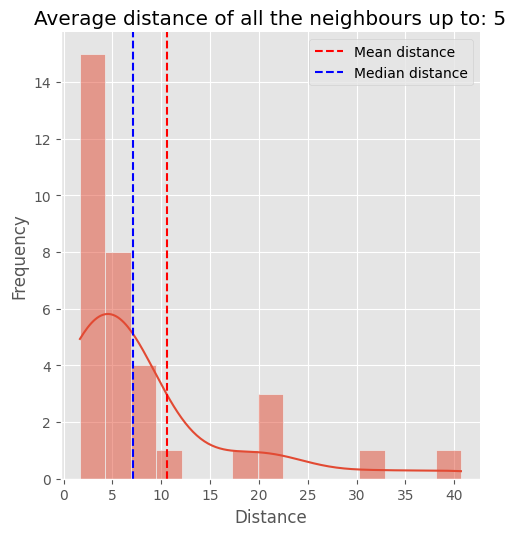

In [6]:
dist_details.get_plot_avg_dist()

## Test out autocorrelation for an example feature

Let's test `Population Density`

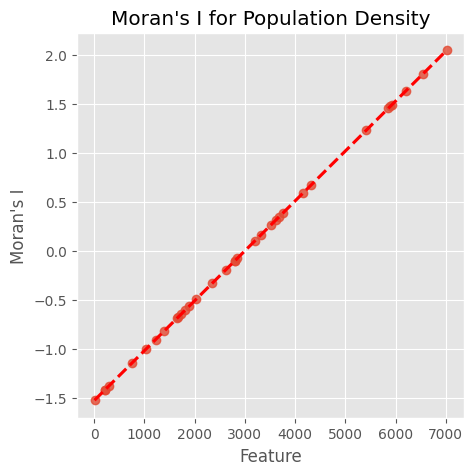

Moran's I: 0.6716484992594537
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.001


In [7]:
from geopandas import GeoDataFrame
# choose k=4
k=4

# select the feature
feature='Population Density'

gdf=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))

# create a spatial weights matrix
w=ps.weights.KNN.from_dataframe(gdf, k=k)

# create a Moran object
moran=Moran(data[feature], w)

# plot the Moran scatter plot
plt.figure(figsize=(5, 5))
sns.regplot(x=data[feature], y=moran.z, line_kws={'color':'red', 'linestyle':'--'})
plt.xlabel('Feature')
plt.ylabel('Moran\'s I')
plt.title(f'Moran\'s I for {feature}')
plt.show()

print('Moran\'s I:', moran.I)
print('Moran\'s Expected I:', moran.EI)
print('Moran\'s I p-value:', moran.p_sim)


In [8]:
def get_moran(feature, k):
	# select the feature
	feature='Population Density'

	gdf=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))

	# create a spatial weights matrix
	w=ps.weights.KNN.from_dataframe(gdf, k=k)

	# create a Moran object
	moran=Moran(data[feature], w, permutations=9999)

	print('Moran\'s I:', moran.I)
	print('Moran\'s Expected I:', moran.EI)
	print('Moran\'s I p-value:', moran.p_sim)

	return None

for i in range(2, 6):
	print(f'For k={i}')
	get_moran('Population Density', i)


For k=2
Moran's I: 0.7345791369817825
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.0001
For k=3
Moran's I: 0.6661154765400408
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.0001
For k=4
Moran's I: 0.6716484992594537
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.0001
For k=5
Moran's I: 0.623149176456302
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.0001


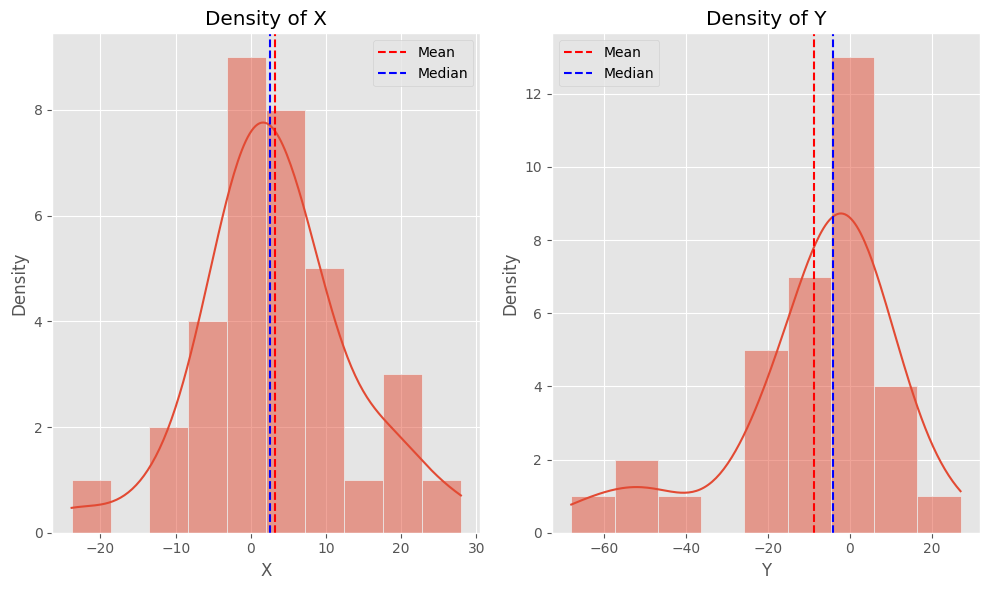

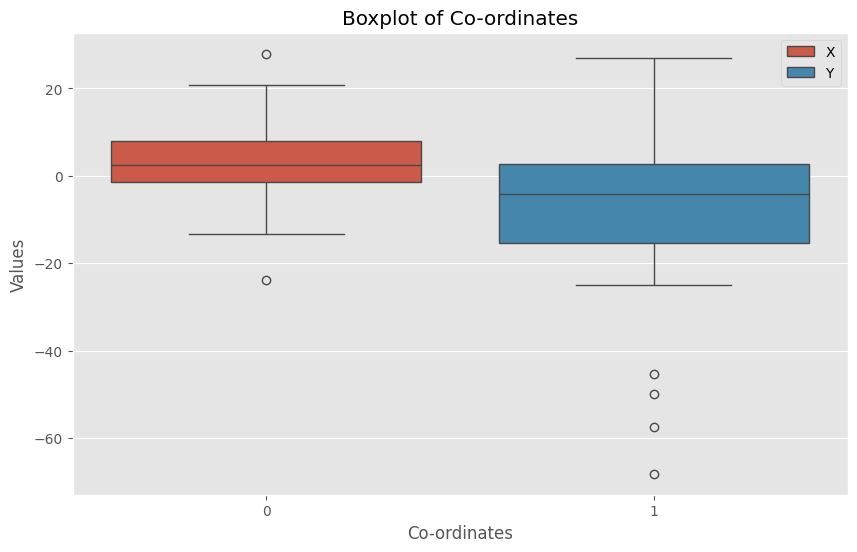

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame with 'cart_x' and 'cart_y' columns

plt.figure(figsize=(10, 6))

# Subplot 1: Density of X
plt.subplot(1, 2, 1)
sns.histplot(data['cart_x'], kde=True)
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Density of X')
# plot mean and median of X
plt.axvline(data['cart_x'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(data['cart_x'].median(), color='blue', linestyle='--', label='Median')
# show legend
plt.legend()

# Subplot 2: Density of Y
plt.subplot(1, 2, 2)
sns.histplot(data['cart_y'], kde=True)
plt.xlabel('Y')
plt.ylabel('Density')
plt.title('Density of Y')
# plot mean and median of Y
plt.axvline(data['cart_y'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(data['cart_y'].median(), color='blue', linestyle='--', label='Median')
# show legend
plt.legend()



# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# boxplot of the co-ordinates
suburb_locs=zip(data['cart_x'], data['cart_y'])
suburb_locs=list(suburb_locs)
suburb_locs=np.array(suburb_locs)
plt.figure(figsize=(10, 6))
sns.boxplot(data=suburb_locs)
plt.xlabel('Co-ordinates')
plt.ylabel('Values')
plt.title('Boxplot of Co-ordinates')
plt.legend(['X', 'Y'])
plt.show()

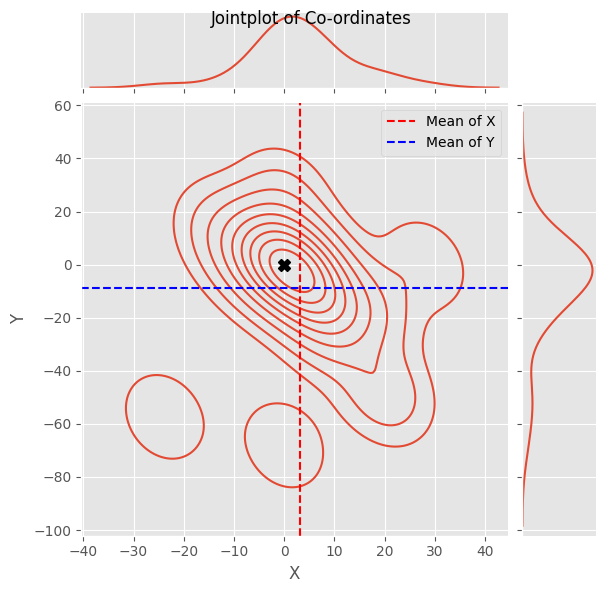

In [10]:
# jointplot of the co-ordinates
sns.jointplot(x='cart_x', y='cart_y', data=data, kind='kde')
plt.xlabel('X')
plt.ylabel('Y')
# show origin
plt.plot(0, 0, 'X', markersize=9, color='black')
plt.legend(['Melbourne GPO'])
# also show the mean of the co-ordinates
plt.axvline(data['cart_x'].mean(), color='red', linestyle='--', label='Mean of X')
plt.axhline(data['cart_y'].mean(), color='blue', linestyle='--', label='Mean of Y')
plt.legend()
plt.suptitle('Jointplot of Co-ordinates')
plt.show()

In [11]:
# let's pick the feature category 'Services'
feature_category='Services'
# get the features in the selected category
features=fcmap[feature_category]
# select the features
data_services=data[features]
data_services.head()

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0,1,1,0,10,5,0,0,0,2,...,31,0,4,3,0,0,1,0,0,0
1,0,0,1,0,13,1,0,1,1,4,...,0,0,1,2,2,0,1,0,0,0
2,1,0,1,0,15,0,0,1,1,8,...,0,0,2,6,1,1,0,0,0,0
3,0,1,0,0,30,8,0,7,9,9,...,179,45,10,5,2,0,0,0,0,0
4,0,0,1,0,13,1,0,1,0,5,...,150,0,3,4,1,1,0,0,0,0


Correlation between the first two suburbs: PearsonRResult(statistic=np.float64(0.20389225159217567), pvalue=np.float64(0.33925866318638714))


C:\Users\subha\AppData\Local\Temp\ipykernel_10276\3367062486.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr=stats.pearsonr(data1, data2)


Filling nan values with 0


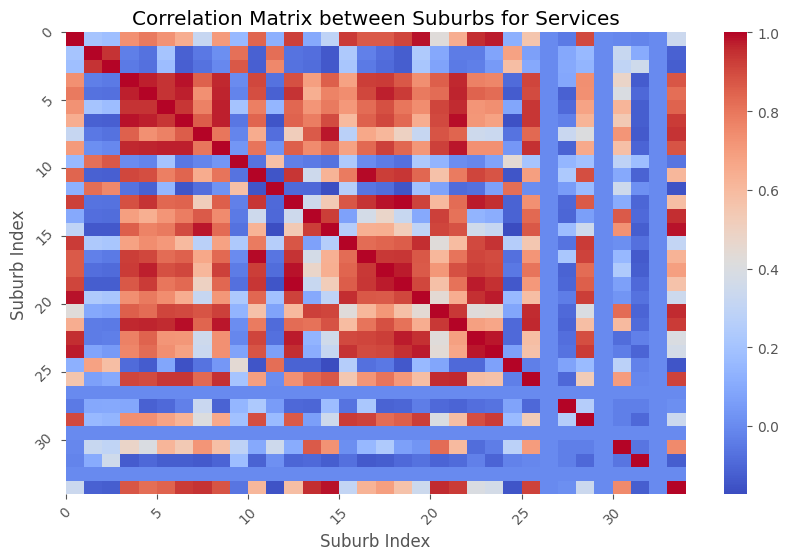

In [12]:
def compute_corr_service(sub_idx1, sub_idx2):
	# select the data
	data1=data_services.iloc[sub_idx1]
	data2=data_services.iloc[sub_idx2]
	# compute the correlation
	corr=stats.pearsonr(data1, data2)
	return corr

# compute the correlation between the first two suburbs
sub_idx1=0
sub_idx2=1
corr=compute_corr_service(sub_idx1, sub_idx2)
print(f'Correlation between the first two suburbs: {corr}')

# plot the correlation matrix between towns i, j
corr_mat=np.zeros((data_services.shape[0], data_services.shape[0]))
for i in range(data_services.shape[0]):
	for j in range(data_services.shape[0]):
		corr=compute_corr_service(i, j)
		corr_mat[i, j]=corr[0]

# fill nan values with 0
corr_mat=np.nan_to_num(corr_mat)
print('Filling nan values with 0')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat, cmap='coolwarm')

plt.title('Correlation Matrix between Suburbs for Services')
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
plt.xticks(ticks=np.arange(0,data_services.shape[0],5), labels=np.arange(0,data_services.shape[0],5), rotation=45)
plt.yticks(ticks=np.arange(0,data_services.shape[0],5), labels=np.arange(0,data_services.shape[0],5), rotation=45)
plt.show()

In [13]:
# compute GWR on the correlation matrix


In [14]:
data.iloc[32]

Community Name                                                      Waterways
Region                                                  Southern Metropolitan
Map reference                                                               2
Grid reference                                                             C4
Location                                                27km SSE of Melbourne
                                                                ...          
Category 4 & 5 emergency department presentations, %                53.754108
geo_lat                                                            -38.038519
geo_lon                                                            145.080728
cart_x                                                              10.339287
cart_y                                                             -24.983131
Name: 32, Length: 230, dtype: object

In [15]:
# flatten w matrix
w_flatten=w.full()[0].flatten()
corr_flat=corr_mat.flatten()
len(corr_flat), len(w_flatten)

# find the correlation between the spatial weights and the correlation matrix
corr_w=stats.pearsonr(corr_flat, w_flatten)
print(f'Correlation between the spatial weights and the correlation matrix: {corr_w}')
# do spearman correlation
corr_w=stats.spearmanr(corr_flat, w_flatten)
print(f'Spearman Correlation between the spatial weights and the correlation matrix: {corr_w}')

Correlation between the spatial weights and the correlation matrix: PearsonRResult(statistic=np.float64(0.04243399072435882), pvalue=np.float64(0.14934630669733057))
Spearman Correlation between the spatial weights and the correlation matrix: SignificanceResult(statistic=np.float64(0.034018577878345085), pvalue=np.float64(0.2477978136226533))


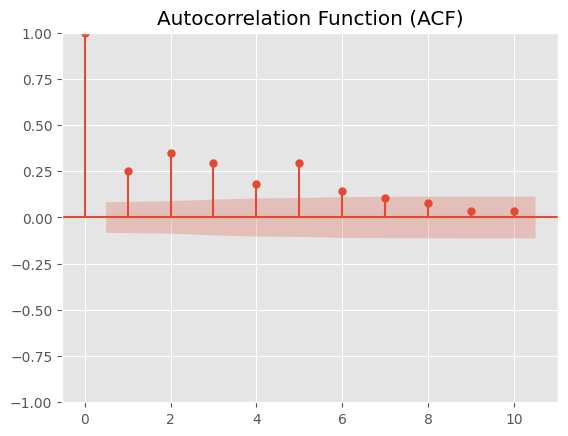

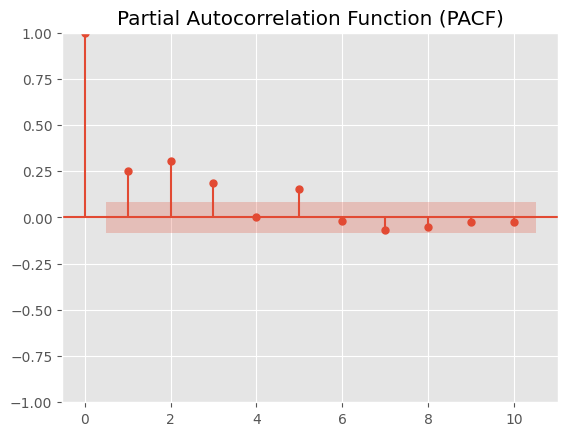

In [16]:
# compute autocorrelation for flattened correlation matrix
# (don't use moran's I as it is not suitable for this case)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example : A univariate time series

# consider only the upper triangular part of the correlation matrix
corr_flat=corr_mat[np.triu_indices(corr_mat.shape[0], k=1)]


# ACF plot
plot_acf(corr_flat, lags=10)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plot_pacf(corr_flat, lags=10)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


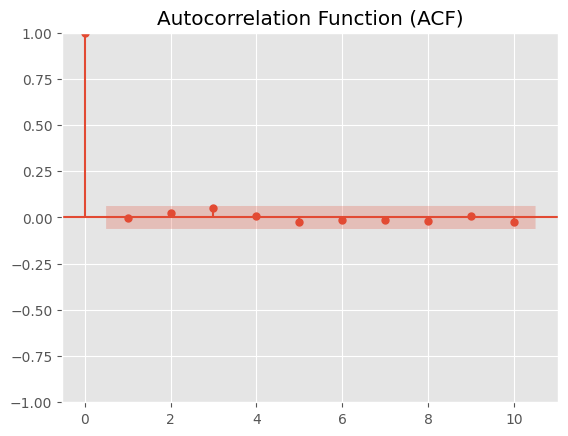

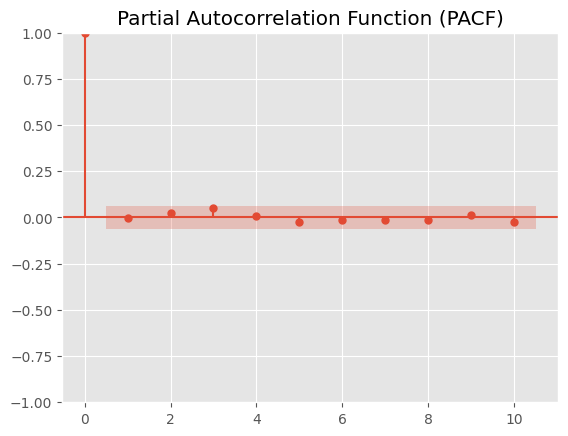

In [17]:
# compute autocorrelation for flattened correlation matrix
# (don't use moran's I as it is not suitable for this case)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example : A univariate time series

# consider only the upper triangular part of the correlation matrix
sample_random=np.random.normal(0, 1, 1000)


# ACF plot
plot_acf(sample_random, lags=10)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plot_pacf(sample_random, lags=10)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [18]:
X=suburb_locs
# compute geographical weight matrix, W_ij=exp(-d_ij^2)
def get_geographical_weights(X):
	n=X.shape[0]
	W=np.zeros((n, n))
	for i in range(n):
		for j in range(n):
			W[i, j]=np.exp(-np.linalg.norm(X[i]-X[j])**2)
	return W

W_geo=get_geographical_weights(X)

P=(X.T@W_geo@X)
P_inv=np.linalg.inv(P)
Q=(X.T@W_geo@corr_mat)
B=P_inv@Q
print('B:', B)

# compute R^2
R_sq=1-(np.linalg.norm(Q-P@B)**2/np.linalg.norm(Q)**2)
print('R^2:', R_sq)
# compute p-value

## compute variance of residuals
residuals=Q-P@B
var_res=np.var(residuals)
print('Variance of residuals:', var_res)

B: [[ 0.0047317  -0.00324321 -0.0025575   0.01876476  0.01669108  0.01761757
   0.02010535  0.02278729  0.01896248 -0.00222184  0.01230603 -0.00271046
   0.01052222  0.02274286  0.02332091  0.00395351  0.01248998  0.0133418
   0.01014937  0.00463216  0.02171511  0.02010144  0.00602988  0.00520629
  -0.00246934  0.02029451  0.          0.0028086   0.00560062  0.
   0.01885683  0.00077339  0.          0.0231201 ]
 [-0.00620312  0.00108712  0.00062611 -0.0061196  -0.00646016 -0.00545724
  -0.00585633 -0.0037812  -0.00587303  0.00070291 -0.00661174  0.00107652
  -0.0068082  -0.00242207 -0.00388059 -0.00575954 -0.00654168 -0.0066921
  -0.0068556  -0.00604689 -0.0040549  -0.00567904 -0.00673062 -0.00637482
   0.00103373 -0.00506912  0.          0.00025239 -0.00590122  0.
  -0.00055134 -0.00135858  0.         -0.0040908 ]]
R^2: 1.0
Variance of residuals: 2.7123576470432135e-29


Correlation between distance and correlation: PearsonRResult(statistic=np.float64(0.34013063364870844), pvalue=np.float64(1.0651612028518989e-32))


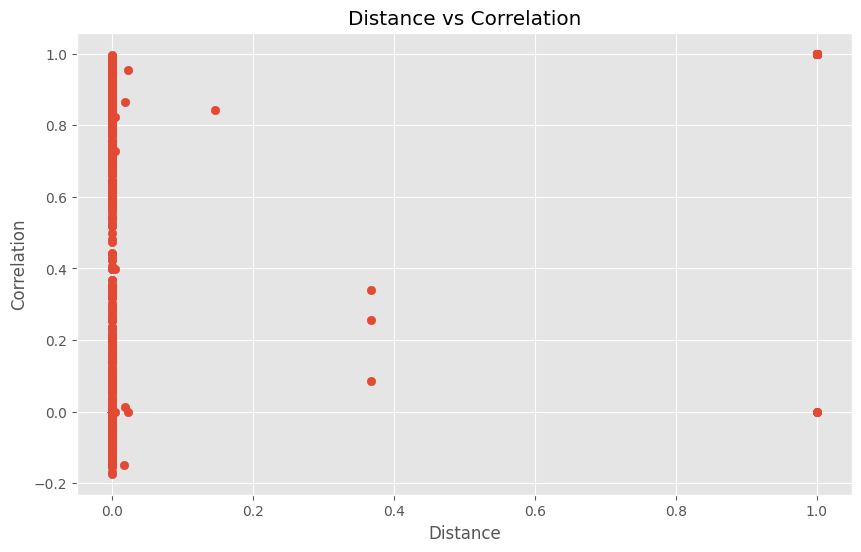

In [19]:
## Compute correlation between distance and correlation 

W_geo_flat=np.triu(W_geo).flatten()
corr_flat=np.triu(corr_mat).flatten()
corr_dist=stats.pearsonr(W_geo_flat, corr_flat)
print('Correlation between distance and correlation:', corr_dist)
# plot 
plt.figure(figsize=(10, 6))
plt.scatter(W_geo_flat, corr_flat)
plt.xlabel('Distance')
plt.ylabel('Correlation')
plt.title('Distance vs Correlation')
plt.show()


In [20]:
# compute correlation between geographical position and feature in the selected category
for i in range(data_services.shape[1]):
	corr_x=stats.pearsonr(data['cart_x'], data_services.iloc[:, i])
	corr_y=stats.pearsonr(data['cart_y'], data_services.iloc[:, i])
	print(f'Correlation between X and feature {i}: {corr_x}')
	print(f'Correlation between Y and feature {i}: {corr_y}')
	


Correlation between X and feature 0: PearsonRResult(statistic=np.float64(-0.11401135385316387), pvalue=np.float64(0.5208554707666634))
Correlation between Y and feature 0: PearsonRResult(statistic=np.float64(0.18406718665923286), pvalue=np.float64(0.297375271919306))
Correlation between X and feature 1: PearsonRResult(statistic=np.float64(0.1282386050196917), pvalue=np.float64(0.46981720571840346))
Correlation between Y and feature 1: PearsonRResult(statistic=np.float64(0.1485450224199088), pvalue=np.float64(0.40179100064632545))
Correlation between X and feature 2: PearsonRResult(statistic=np.float64(-0.21631602188930324), pvalue=np.float64(0.21916141552826504))
Correlation between Y and feature 2: PearsonRResult(statistic=np.float64(0.264452351916436), pvalue=np.float64(0.13069050150396122))
Correlation between X and feature 3: PearsonRResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Correlation between Y and feature 3: PearsonRResult(statistic=np.float64(nan), pvalue=np.flo

C:\Users\subha\AppData\Local\Temp\ipykernel_10276\428890621.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_x=stats.pearsonr(data['cart_x'], data_services.iloc[:, i])
C:\Users\subha\AppData\Local\Temp\ipykernel_10276\428890621.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_y=stats.pearsonr(data['cart_y'], data_services.iloc[:, i])


In [21]:
# compute multivariate regression. (cart_x, cart_y) -> feature_i of the selected category
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def compute_multivariate_regression(X, y):
	# create a linear regression object
	lr=LinearRegression()
	# fit the model
	lr.fit(X, y)
	# compute R^2
	R_sq=r2_score(y, lr.predict(X))
	return R_sq

# select the feature
for feature_idx in range(data_services.shape[1]):
	y=data_services.iloc[:, feature_idx]
	X=data[['cart_x', 'cart_y']]
	R_sq=compute_multivariate_regression(X, y)

	print(f'R^2 for feature {feature_idx}: {R_sq}')


R^2 for feature 0: 0.039922057639920294
R^2 for feature 1: 0.048426021755184734
R^2 for feature 2: 0.09727157663078345
R^2 for feature 3: 1.0
R^2 for feature 4: 0.1073485192917969
R^2 for feature 5: 0.06219338418249687
R^2 for feature 6: 0.03383860079344625
R^2 for feature 7: 0.09505817878349732
R^2 for feature 8: 0.11360859362005282
R^2 for feature 9: 0.10546005747775666
R^2 for feature 10: 0.04031787822482491
R^2 for feature 11: 0.08968996495497916
R^2 for feature 12: 0.19224427673338995
R^2 for feature 13: 0.11586988179800073
R^2 for feature 14: 0.09323150733731611
R^2 for feature 15: 0.1324243790587083
R^2 for feature 16: 0.2317705748250597
R^2 for feature 17: 0.17509152674353856
R^2 for feature 18: 0.08761882440987145
R^2 for feature 19: 0.030383879538787406
R^2 for feature 20: 0.04012896614752537
R^2 for feature 21: 0.0060380852033186105
R^2 for feature 22: 0.01738271891832055
R^2 for feature 23: 1.0


In [22]:
import numpy as np
import pandas as pd
import libpysal as ps
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import geopandas as gpd

# Create the DataFrame with population density and coordinates
df = pd.DataFrame({
    'target_feat': gdf[fcmap['Services'][1]],
    'X': gdf.geometry.x,
    'Y': gdf.geometry.y
})

# Prepare the dependent variable (y) and the independent variables (X)
y = np.array(df['target_feat']).reshape(-1, 1)
X = np.array(df[['X', 'Y']])

# Define the coordinates for GWR
coords = np.array(list(zip(df['X'], df['Y'])))

# Select the optimal bandwidth using a fixed bandwidth method
optimal_bw = Sel_BW(coords, y, X).search(bw_min=2, bw_max=20)

# Fit the GWR model using the optimal bandwidth
gwr_model = GWR(coords, y, X, optimal_bw, fixed=False)
gwr_results = gwr_model.fit()

# Print the results summary and the R-squared value
print(gwr_results.summary())
print('R2:', gwr_results.R2)


Model type                                                         Gaussian
Number of observations:                                                  34
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             34.844
Log-likelihood:                                                     -48.661
AIC:                                                                103.322
AICc:                                                               106.701
BIC:                                                                -74.473
R2:                                                                   0.048
Adj. R2:                                                             -0.013

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [23]:
# Extract local coefficients
local_coefficients = gwr_results.params  # shape is (n, number of predictors + 1 for intercept)

# Convert to a DataFrame for better readability
# Assuming X and Y are the first two predictors, and the intercept is the first column
coefficients_df = pd.DataFrame(local_coefficients, columns=['Intercept', 'X', 'Y'])

# Add coordinates back to the DataFrame for spatial analysis
coefficients_df['X_coord'] = df['X']
coefficients_df['Y_coord'] = df['Y']

# Inspect the coefficients
print(coefficients_df)
# print unique values of the intercept



    Intercept         X         Y    X_coord    Y_coord
0    0.904993 -0.042638 -0.055979  -4.230377   4.251470
1    1.030237  0.007843 -0.054125  -9.212552   3.839001
2    0.784370  0.008399 -0.037076   0.000000  27.049690
3    0.951970  0.001598 -0.048574  27.933349   0.047723
4    1.020082 -0.041560 -0.087870   0.000000  12.021947
5    0.890287 -0.017108 -0.022373  -5.528560   2.302152
6    1.075152 -0.012173 -0.084161  -4.955834  12.033903
7    1.608603  0.057631  0.100248   7.767033  -7.788594
8    1.104429  0.066589  0.027019   5.647293  -5.665173
9    1.093351  0.013217 -0.068377 -13.381261  13.470574
10   1.307472  0.147455  0.121395   8.036223 -19.432539
11   1.434825  0.129909  0.122924   6.119386 -14.806515
12   1.268887  0.151492  0.120841   9.187364 -22.207922
13   1.589777  0.091410  0.116528   9.180800  -9.203898
14   1.226119  0.086418  0.078053  17.673643 -17.690511
15   0.938016 -0.030751 -0.001850  -1.410610   1.416910
16   1.037325 -0.062979 -0.096961   4.230377   4

In [24]:
# Extract residuals
residuals = gwr_results.resid_response

# Add residuals to the DataFrame
coefficients_df['Residuals'] = residuals

# Identify significant residuals (e.g., high absolute residuals)
residual_threshold = coefficients_df['Residuals'].abs().mean() + 2 * coefficients_df['Residuals'].abs().std()
hotspots_residuals = coefficients_df[coefficients_df['Residuals'].abs() > residual_threshold]

print("Hotspots for high residuals (areas with large prediction errors):")
print(hotspots_residuals[['X_coord', 'Y_coord', 'Residuals']])


Hotspots for high residuals (areas with large prediction errors):
    X_coord   Y_coord  Residuals
5 -5.528560  2.302152   2.066638
8  5.647293 -5.665173   2.672595


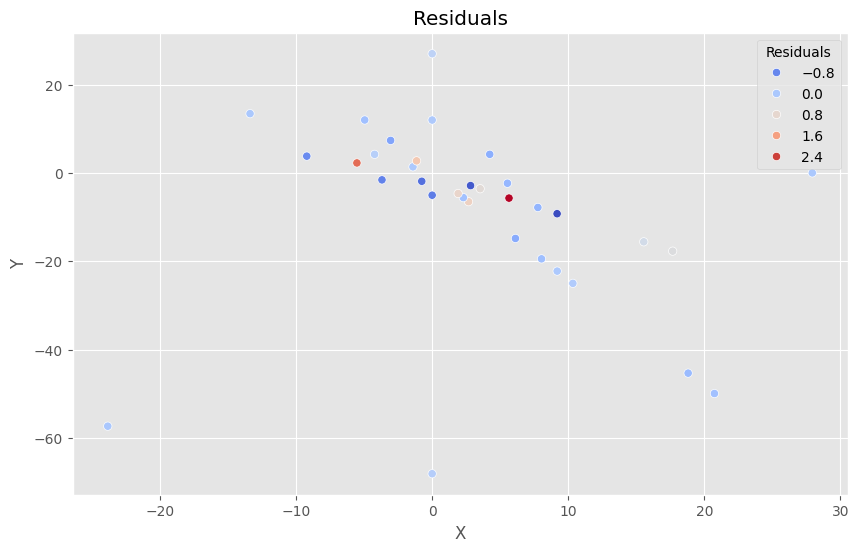

In [25]:
# plot the residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X_coord', y='Y_coord', data=coefficients_df, hue='Residuals', palette='coolwarm')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Residuals')
plt.show()

In [26]:
fcmap['Services'][1]

'Private Hospitals'

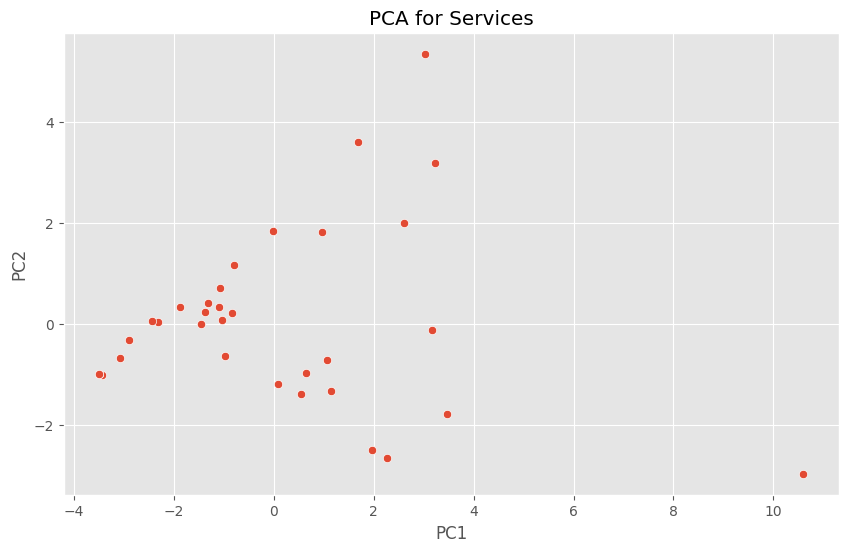

In [27]:
# compute PCA on the selected category
# select the feature
features=fcmap['Services']
data_services=data[features]
data_services.head()

# standardize the data
scaler=StandardScaler()
data_services_scaled=scaler.fit_transform(data_services)

# create a PCA object
pca=PCA(n_components=2)
# fit the data
pca.fit(data_services_scaled)
# transform the data
data_services_pca=pca.transform(data_services_scaled)

# create a DataFrame
data_services_pca=pd.DataFrame(data_services_pca, columns=['PC1', 'PC2'])
data_services_pca.head()

# plot the PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=data_services_pca)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA for Services')
plt.show()



1D MDS Coordinates:
        MDS1 Location
0 -3.209390        A
1  1.391468        B
2 -3.882436        C
3  5.700358        D


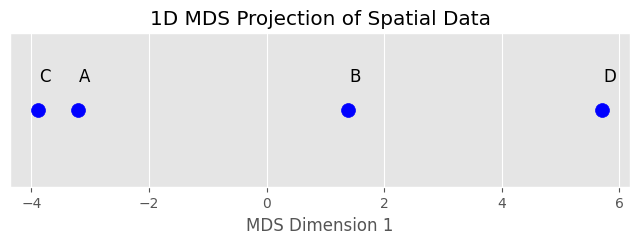

Stress: 27.784947055443055

2D MDS Coordinates:
        MDS1      MDS2 Location
0  4.054357  3.170365        A
1 -1.993525  1.094976        B
2  2.060799 -0.590656        C
3 -4.121631 -3.674684        D


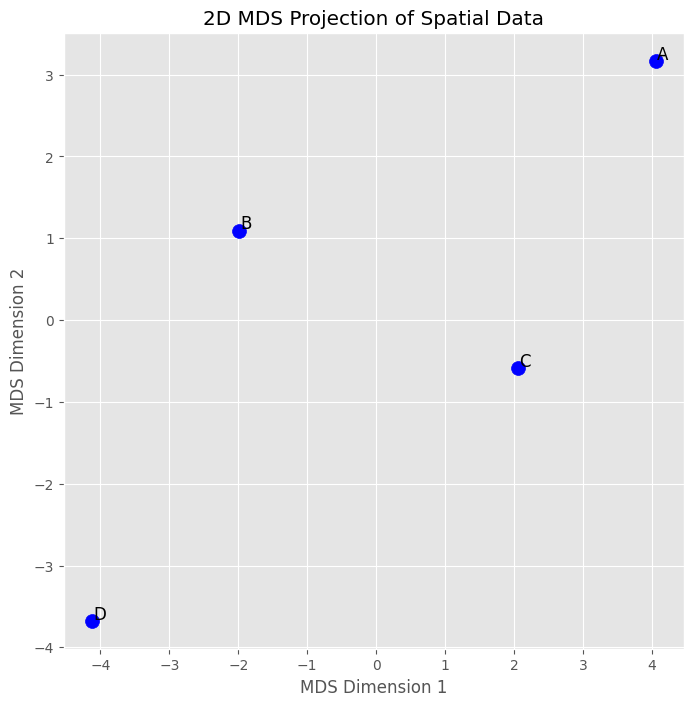

Stress: 0.005641064505162221


In [28]:
from sklearn.manifold import MDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame with spatial coordinates
df = pd.DataFrame({
    'Location': ['A', 'B', 'C', 'D'],
    'X': [0, 3, 4, 8],  # Example X-coordinates
    'Y': [0, 4, 1, 5],   # Example Y-coordinates
    'Z': [0, 4, 1, 5]   # Example Z-coordinates
})

# Create a 2D array of coordinates
coords = df[['X', 'Y', 'Z']].values

# Compute the Euclidean distance matrix
from sklearn.metrics import pairwise_distances
distance_matrix = pairwise_distances(coords, metric='euclidean')

# Apply MDS with 1 dimension
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42)
mds_1d = mds.fit_transform(distance_matrix)

# Create a DataFrame for the MDS results
mds_df = pd.DataFrame(mds_1d, columns=['MDS1'])
mds_df['Location'] = df['Location']

# Display the 1D MDS result
print("\n1D MDS Coordinates:\n", mds_df)

# Plot the 1D result
plt.figure(figsize=(8, 2))
plt.scatter(mds_df['MDS1'], [0] * len(mds_df), color='blue', s=100)  # Plot on a line (y=0)

# Annotate points with location names
for i, row in mds_df.iterrows():
    plt.text(row['MDS1'] + 0.02, 0.02, row['Location'], fontsize=12)

plt.title('1D MDS Projection of Spatial Data')
plt.yticks([])
plt.xlabel('MDS Dimension 1')
plt.grid(True)
plt.show()

# print stress
print('Stress:', mds.stress_)

# Apply MDS with 2 dimensions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_2d = mds.fit_transform(distance_matrix)

# Create a DataFrame for the MDS results
mds_df = pd.DataFrame(mds_2d, columns=['MDS1', 'MDS2'])
mds_df['Location'] = df['Location']

# Display the 2D MDS result
print("\n2D MDS Coordinates:\n", mds_df)

# Plot the 2D result
plt.figure(figsize=(8, 8))
plt.scatter(mds_df['MDS1'], mds_df['MDS2'], color='blue', s=100)

# Annotate points with location names
for i, row in mds_df.iterrows():
	plt.text(row['MDS1'] + 0.02, row['MDS2'] + 0.02, row['Location'], fontsize=12)
      
plt.title('2D MDS Projection of Spatial Data')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()

# print stress
print('Stress:', mds.stress_)


In [29]:
import numpy as np
import pandas as pd
import libpysal as ps
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import geopandas as gpd

# Create the DataFrame with population density and coordinates
df = pd.DataFrame({
    'target_feat': gdf[fcmap['Services'][1]],
    'X': gdf.geometry.x,
    'Y': gdf.geometry.y
})

# Prepare the dependent variable (y) and the independent variables (X)
y = np.array(df['target_feat']).reshape(-1, 1)
X = np.array(df[['X', 'Y']])

# Define the coordinates for GWR
coords = np.array(list(zip(df['X'], df['Y'])))

# Select the optimal bandwidth using a fixed bandwidth method
optimal_bw = Sel_BW(coords, y, X).search(bw_min=2, bw_max=5)

# Fit the GWR model using the optimal bandwidth
gwr_model = GWR(coords, y, X, optimal_bw, fixed=False)
gwr_results = gwr_model.fit()

# Print the results summary and the R-squared value
print(gwr_results.summary())
print('R2:', gwr_results.R2)


LinAlgError: Matrix is singular.

In [30]:
# compute PCA on the selected category
def compute_service_pca(index):
    # select the index
    features=fcmap['Services']
    # select the suburb
    data_services=data[features]
    # standardize the data	
    scaler=StandardScaler()
    data_services_scaled=scaler.fit_transform(data_services)
    # select the particular suburb
    # data_services_scaled=data_services_scaled[index].reshape(1, -1)
    # create a PCA object
    pca=PCA(n_components=1)
    # fit the data
    pca.fit(data_services_scaled)
    # transform the data
    data_services_pca=pca.transform(data_services_scaled)
    return data_services_pca

# compute PCA for the first suburb
data_services_pca=compute_service_pca(1)

data_services_pca

array([[-1.10168301],
       [-1.37045906],
       [-0.82985354],
       [ 3.22368665],
       [-0.80299705],
       [10.59953028],
       [ 1.68099603],
       [ 0.95980417],
       [ 0.55673037],
       [-3.42690964],
       [-0.01461761],
       [-0.97829915],
       [-1.31488446],
       [-2.30709713],
       [ 3.02326757],
       [ 0.64067423],
       [ 2.61285728],
       [ 1.07053675],
       [-2.4414398 ],
       [-1.4571639 ],
       [ 1.96791987],
       [-1.87293446],
       [-2.89490627],
       [ 2.26191663],
       [ 1.15591711],
       [ 3.16277126],
       [-3.49650529],
       [-1.02819253],
       [ 3.46857233],
       [-3.49650529],
       [ 0.09437025],
       [-3.07975465],
       [-3.49650529],
       [-1.06884264]])

In [31]:
import numpy as np
import pandas as pd
import libpysal as ps
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import geopandas as gpd

# Create the DataFrame with population density and coordinates
# df = pd.DataFrame({
#     'target_feat': y,
#     'X': gdf.geometry.x,
#     'Y': gdf.geometry.y
# })
yy=data_services.sum(axis=1)
yy=yy.values.reshape(-1, 1)
print(yy.shape, y.shape)
# Prepare the dependent variable (y) and the independent variables (X)
y = np.array(df['target_feat']).reshape(-1, 1)
X = np.array(df[['X', 'Y']])

# Define the coordinates for GWR
coords = np.array(list(zip(df['X'], df['Y'])))

# Select the optimal bandwidth using a fixed bandwidth method
optimal_bw = Sel_BW(coords, yy, X).search(bw_min=2, bw_max=15)

# Fit the GWR model using the optimal bandwidth
gwr_model = GWR(coords, yy, X, optimal_bw, fixed=False)
gwr_results = gwr_model.fit()

# Print the results summary and the R-squared value
print(gwr_results.summary())
print('R2:', gwr_results.R2)


(34, 1) (34, 1)
Model type                                                         Gaussian
Number of observations:                                                  34
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         905467.842
Log-likelihood:                                                    -221.471
AIC:                                                                448.943
AICc:                                                               452.322
BIC:                                                             905358.525
R2:                                                                   0.155
Adj. R2:                                                              0.100

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- -

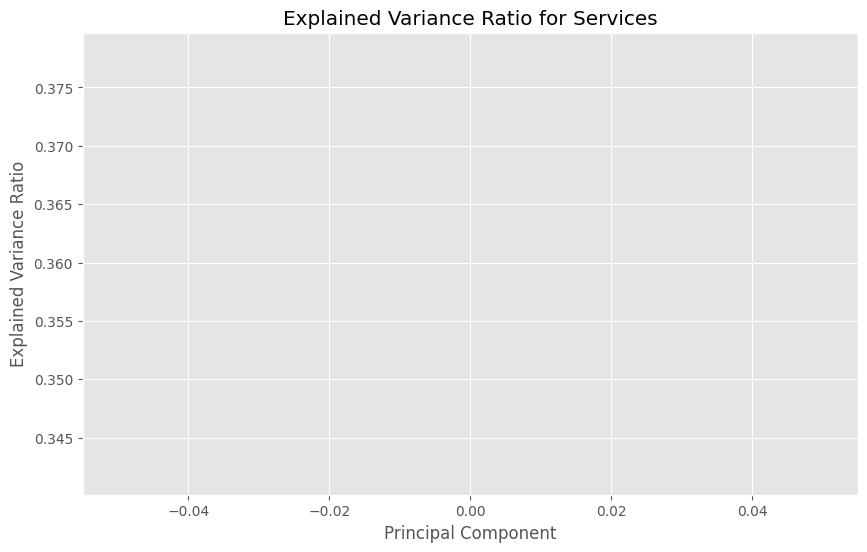

In [32]:
features=fcmap['Services']
# select the suburb
data_services=data[features]
# standardize the data	
scaler=StandardScaler()
data_services_scaled=scaler.fit_transform(data_services)
# select the particular suburb
# data_services_scaled=data_services_scaled[index].reshape(1, -1)
# create a PCA object
pca=PCA(n_components=1)
# fit the data
pca.fit(data_services_scaled)
# transform the data
data_services_pca=pca.transform(data_services_scaled)


# plot the eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Services')
plt.show()

In [33]:
pca.singular_values_

array([16.40738673])

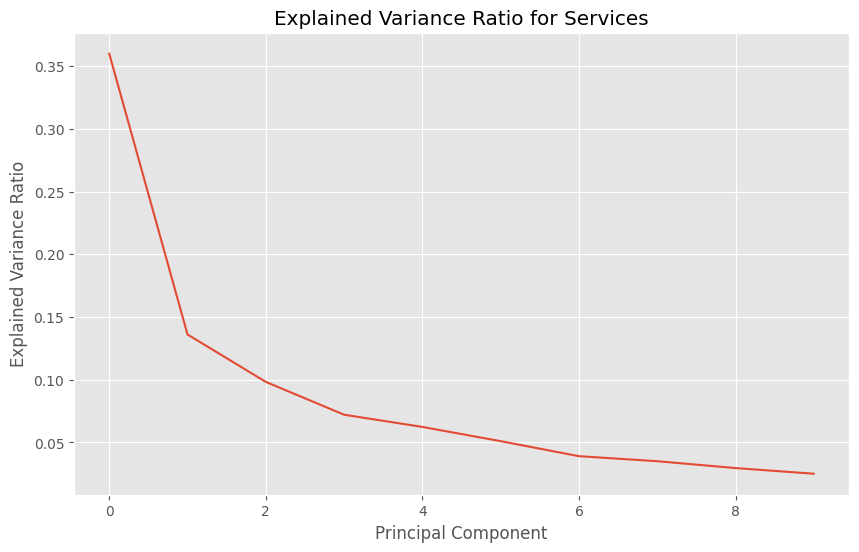

In [34]:
features=fcmap['Services']
# select the suburb
data_services=data[features]
# standardize the data	
scaler=StandardScaler()
data_services_scaled=scaler.fit_transform(data_services)
# select the particular suburb
# data_services_scaled=data_services_scaled[index].reshape(1, -1)
# create a PCA object
pca=PCA(n_components=10)
# fit the data
pca.fit(data_services_scaled)
# transform the data
data_services_pca=pca.transform(data_services_scaled)


# plot the eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Services')
plt.show()

In [35]:
pca.singular_values_

array([16.40738673, 10.08713416,  8.57264589,  7.34229394,  6.82873992,
        6.17575969,  5.40195139,  5.11757076,  4.69991989,  4.32712812])

In [36]:
yy=data_services.sum(axis=1)

In [37]:
yy=yy.values.reshape(-1, 1)

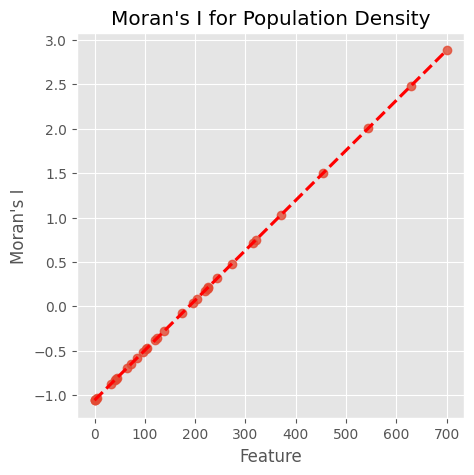

Moran's I: -0.0312113979606866
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.482


In [38]:
from geopandas import GeoDataFrame
# choose k=4
k=2

# select the feature
feature='Population Density'

gdf=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))

# create a spatial weights matrix
w=ps.weights.KNN.from_dataframe(gdf, k=k)

# create a Moran object
moran=Moran(yy, w)

# plot the Moran scatter plot
plt.figure(figsize=(5, 5))
sns.regplot(x=yy, y=moran.z, line_kws={'color':'red', 'linestyle':'--'})
plt.xlabel('Feature')
plt.ylabel('Moran\'s I')
plt.title(f'Moran\'s I for {feature}')
plt.show()

print('Moran\'s I:', moran.I)
print('Moran\'s Expected I:', moran.EI)
print('Moran\'s I p-value:', moran.p_sim)


('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')


c:\Users\subha\miniconda3\Lib\site-packages\scipy\sparse\_data.py:134: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
c:\Users\subha\miniconda3\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 2, 3, 22, 26.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\subha\miniconda3\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 2, 3, 22, 26.
  W.__init__(
c:\Users\subha\miniconda3\Lib\site-packages\esda\moran.py:1084: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


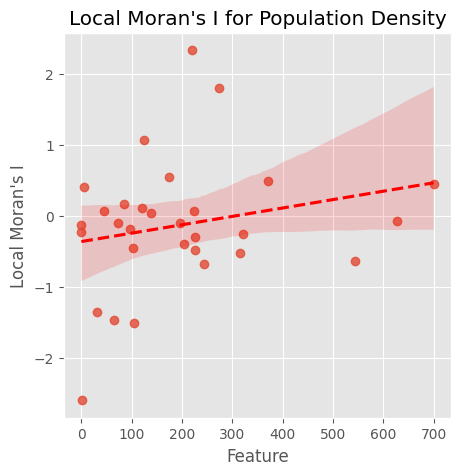

Local Moran's I values: [-2.95142759e-01 -4.09809987e-01 -0.00000000e+00  0.00000000e+00
  3.47329940e-01 -4.49799026e-01 -2.72829251e-01 -7.04498079e-02
  1.02125356e-02 -2.52082505e+00 -1.77287499e-03  9.01634165e-03
 -2.61824311e-03  2.73114532e-03  4.28874966e-01 -6.59444445e-02
  7.00980709e-02 -6.86078274e-02 -1.99225658e-01 -2.69616205e-02
 -2.85442712e-02  3.60369882e-01 -0.00000000e+00 -6.98538469e-03
 -3.14829221e-02  1.90661457e-01 -0.00000000e+00  2.07590104e-02
 -2.00747894e-02 -9.03878016e-02  6.92907127e-03  3.60369882e-01
 -9.49113684e-02 -1.22958565e-01]
Significance: [0.083 0.11  0.001 0.001 0.05  0.28  0.477 0.272 0.302 0.03  0.415 0.483
 0.472 0.446 0.262 0.284 0.311 0.448 0.078 0.458 0.344 0.141 0.001 0.342
 0.383 0.026 0.001 0.497 0.429 0.386 0.49  0.467 0.373 0.338]


In [39]:
import geopandas as gpd
from esda.moran import Moran_Local
from libpysal.weights import DistanceBand
import matplotlib.pyplot as plt
import seaborn as sns

# Define the feature and create a GeoDataFrame
feature = 'Population Density'
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))

# Create a distance-based spatial weights matrix
distance_threshold = 10  # Adjust this based on your data's scale
w = DistanceBand.from_dataframe(gdf, threshold=distance_threshold, binary=False)

# Create a Moran_Local object
local_moran = Moran_Local(yy, w)

# Plot the local Moran's I scatter plot
plt.figure(figsize=(5, 5))
sns.regplot(x=yy, y=local_moran.z_sim, line_kws={'color': 'red', 'linestyle': '--'})
plt.xlabel('Feature')
plt.ylabel('Local Moran\'s I')
plt.title(f'Local Moran\'s I for {feature}')
plt.show()

# Print key statistics
print('Local Moran\'s I values:', local_moran.Is)
print('Significance:', local_moran.p_sim)


('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')


c:\Users\subha\miniconda3\Lib\site-packages\scipy\sparse\_data.py:134: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
c:\Users\subha\miniconda3\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 2, 3, 22, 26.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\subha\miniconda3\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 2, 3, 22, 26.
  W.__init__(


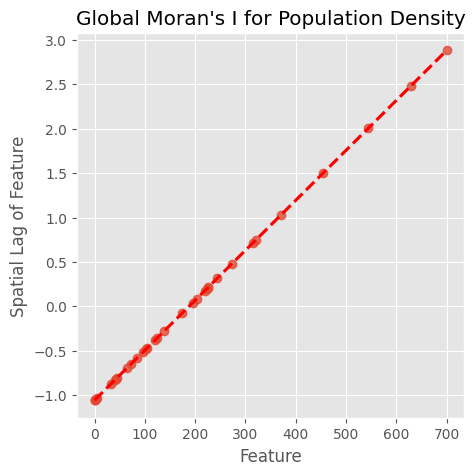

Global Moran's I: -0.10206797755337856
Expected I: -0.030303030303030304
Moran's I p-value: 0.277


In [40]:
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import DistanceBand
import matplotlib.pyplot as plt
import seaborn as sns

# Define the feature and create a GeoDataFrame
feature = 'Population Density'
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))

# Create a distance-based spatial weights matrix
distance_threshold = 10  # Adjust this based on your data's scale
w = DistanceBand.from_dataframe(gdf, threshold=distance_threshold, binary=False)

# Create a Moran object for global Moran's I
moran = Moran(yy, w)

# Plot the global Moran's I scatter plot
plt.figure(figsize=(5, 5))
sns.regplot(x=yy, y=moran.z, line_kws={'color': 'red', 'linestyle': '--'})
plt.xlabel('Feature')
plt.ylabel('Spatial Lag of Feature')
plt.title(f'Global Moran\'s I for {feature}')
plt.show()

# Print key statistics
print('Global Moran\'s I:', moran.I)
print('Expected I:', moran.EI)
print('Moran\'s I p-value:', moran.p_sim)


In [41]:
import geopandas as gpd
from esda.geary import Geary
from libpysal.weights import DistanceBand
import matplotlib.pyplot as plt
import seaborn as sns

# Define the feature and create a GeoDataFrame
feature = 'Population Density'
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))

# Create a distance-based spatial weights matrix
distance_threshold = 10  # Adjust this based on your data's scale
w = DistanceBand.from_dataframe(gdf, threshold=distance_threshold, binary=False)

# Create a Geary object for Geary's C
geary = Geary(gdf[feature], w)

# Print key statistics
print('Geary\'s C:', geary.C)
print('Expected C:', geary.EC)
print('Geary\'s C p-value:', geary.p_sim)

# Visualize the relationship between the variable and its spatial lag
plt.figure(figsize=(5, 5))
sns.regplot(x=gdf[feature], y=geary.z, line_kws={'color': 'red', 'linestyle': '--'})
plt.xlabel('Feature')
plt.ylabel('Spatial Lag of Feature')


('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
Geary's C: 0.44035194006653217
Expected C: 1.0
Geary's C p-value: 0.001


c:\Users\subha\miniconda3\Lib\site-packages\scipy\sparse\_data.py:134: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
c:\Users\subha\miniconda3\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 2, 3, 22, 26.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\subha\miniconda3\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 2, 3, 22, 26.
  W.__init__(


AttributeError: 'Geary' object has no attribute 'z'

<Figure size 500x500 with 0 Axes>

In [42]:
import geopandas as gpd
from esda.geary import Geary
from libpysal.weights import KNN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the feature and create a GeoDataFrame
feature = 'Population Density'
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))

# Create a KNN-based spatial weights matrix to avoid disconnected components
k = 4  # Adjust k based on your preference
w = KNN.from_dataframe(gdf, k=k)

# Create a Geary object for Geary's C
geary = Geary(yy, w)

# Calculate the spatial lag of the feature
# spatial_lag = np.array([sum(w[gdf.index[i]] * gdf[feature].iloc[w.neighbors[i]]) / len(w.neighbors[i]) for i in range(len(gdf))])

# # Visualize the relationship between the variable and its spatial lag
# plt.figure(figsize=(5, 5))
# # sns.regplot(x=gdf[feature], y=spatial_lag, line_kws={'color': 'red', 'linestyle': '--'})
# plt.xlabel('Feature')
# plt.ylabel('Spatial Lag of Feature')
# plt.title(f'Spatial Lag vs. {feature}')
# plt.show()

# Print key statistics
print('Geary\'s C:', geary.C)
print('Expected C:', geary.EC)
print('Geary\'s C p-value:', geary.p_sim)


Geary's C: 0.9743915952044429
Expected C: 1.0
Geary's C p-value: 0.43


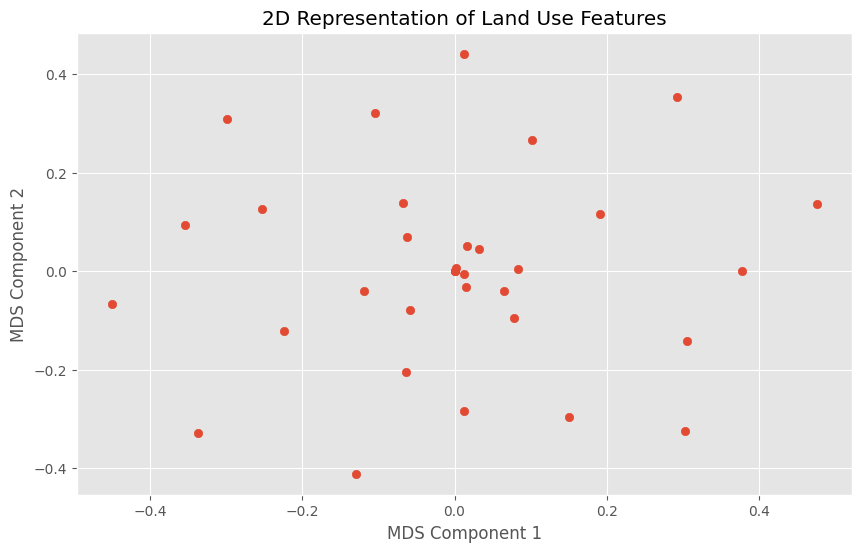

In [43]:
# do a multidimensional scaling (MDS) analysis to visualize the Land Use features in 2D
from sklearn.manifold import MDS

# initialize the MDS model
mds = MDS(n_components=2, dissimilarity='precomputed')

# fit the MDS model
land_use_2d = mds.fit_transform(corr_mat)

# plot the 2D representation of the Land Use features
plt.figure(figsize=(10, 6))
plt.scatter(land_use_2d[:, 0], land_use_2d[:, 1])
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.title('2D Representation of Land Use Features')
plt.show()


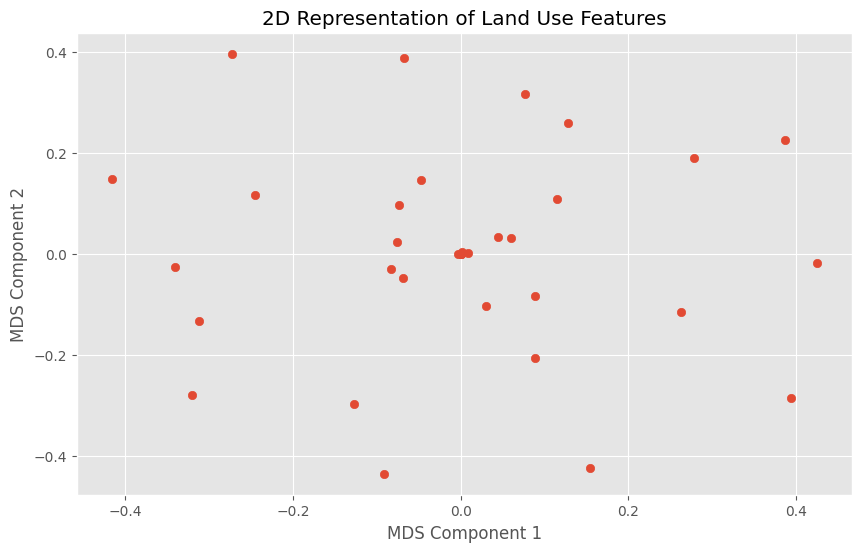

In [44]:
z=yy[:, 0]
# distance in terms in pairwise absolute differences of z
distance_matrix = [[np.abs(z[i] - z[j]) for j in range(len(z))] for i in range(len(z))]

# initialize the MDS model
mds = MDS(n_components=2, dissimilarity='precomputed')

# fit the MDS model
land_use_2d = mds.fit_transform(corr_mat)

# plot the 2D representation of the Land Use features
plt.figure(figsize=(10, 6))
plt.scatter(land_use_2d[:, 0], land_use_2d[:, 1])
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.title('2D Representation of Land Use Features')
plt.show()

In [45]:
mds = MDS(n_components=1, dissimilarity='precomputed')

# fit the MDS model
land_use_1d = mds.fit_transform(corr_mat)

print(land_use_1d)

[[-0.01002493]
 [ 0.04137119]
 [-0.11819778]
 [ 0.446948  ]
 [-0.39605669]
 [ 0.5698087 ]
 [-0.53337455]
 [ 0.02037592]
 [ 0.4990439 ]
 [ 0.0940271 ]
 [ 0.12536286]
 [-0.05981346]
 [ 0.05716128]
 [-0.04441032]
 [-0.11339795]
 [ 0.26884217]
 [-0.23326335]
 [-0.32996723]
 [ 0.16622989]
 [-0.42072595]
 [-0.43804383]
 [-0.2772643 ]
 [-0.06748527]
 [ 0.34161197]
 [-0.0107022 ]
 [ 0.24395669]
 [ 0.        ]
 [-0.00116271]
 [-0.17550542]
 [ 0.        ]
 [ 0.07836392]
 [ 0.00286633]
 [ 0.        ]
 [ 0.27342603]]


In [46]:
# compute correlation
corr=stats.pearsonr(land_use_1d[:,0], z)
corr

PearsonRResult(statistic=np.float64(-0.017788064404402414), pvalue=np.float64(0.9204638339629168))

In [47]:
land_use_1d

array([[-0.01002493],
       [ 0.04137119],
       [-0.11819778],
       [ 0.446948  ],
       [-0.39605669],
       [ 0.5698087 ],
       [-0.53337455],
       [ 0.02037592],
       [ 0.4990439 ],
       [ 0.0940271 ],
       [ 0.12536286],
       [-0.05981346],
       [ 0.05716128],
       [-0.04441032],
       [-0.11339795],
       [ 0.26884217],
       [-0.23326335],
       [-0.32996723],
       [ 0.16622989],
       [-0.42072595],
       [-0.43804383],
       [-0.2772643 ],
       [-0.06748527],
       [ 0.34161197],
       [-0.0107022 ],
       [ 0.24395669],
       [ 0.        ],
       [-0.00116271],
       [-0.17550542],
       [ 0.        ],
       [ 0.07836392],
       [ 0.00286633],
       [ 0.        ],
       [ 0.27342603]])

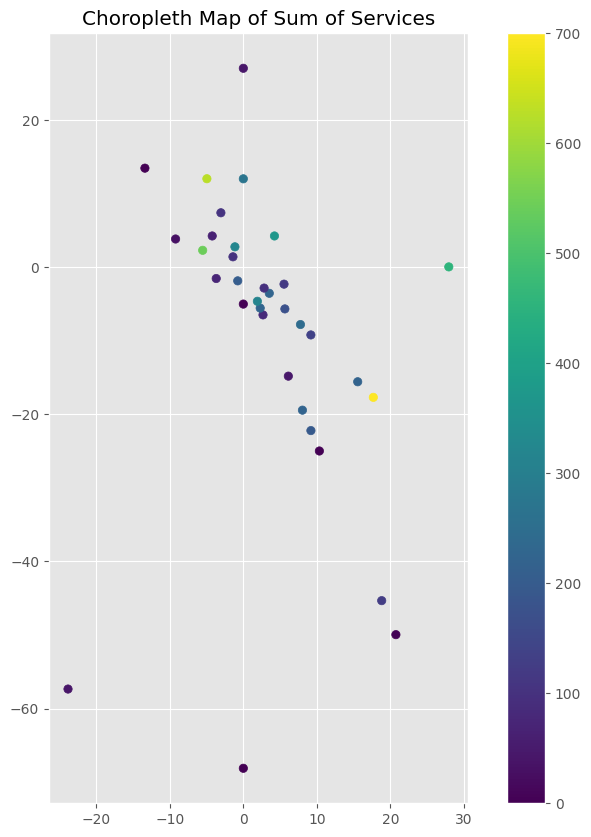

In [30]:
data_services.sum(axis=1)

# do a choropleth map of the sum of the services
import geopandas as gpd
import matplotlib.pyplot as plt

sum_services = data_services.sum(axis=1)
new_df=pd.DataFrame({'cart_x': data['cart_x'], 'cart_y': data['cart_y'], 'sum_services': sum_services})
gdf = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df['cart_x'], new_df['cart_y']))

# plot the choropleth map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='sum_services', cmap='viridis', legend=True, ax=ax)
plt.title('Choropleth Map of Sum of Services')
plt.show()


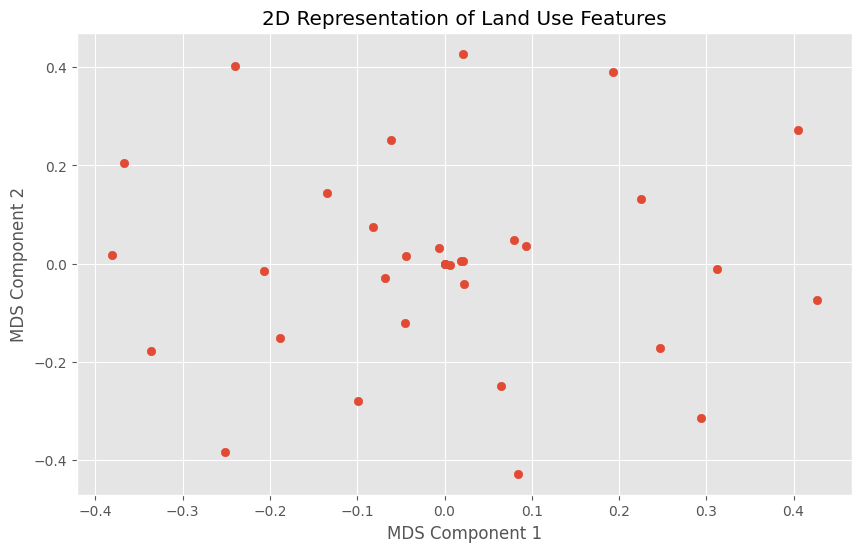

In [49]:
z=yy[:, 0]
# distance in terms in pairwise absolute differences of z
distance_matrix = [[np.abs(z[i] - z[j]) for j in range(len(z))] for i in range(len(z))]

# initialize the MDS model
mds = MDS(n_components=2, dissimilarity='precomputed')

# fit the MDS model
land_use_2d = mds.fit_transform(corr_mat)

# plot the 2D representation of the Land Use features
plt.figure(figsize=(10, 6))
plt.scatter(land_use_2d[:, 0], land_use_2d[:, 1])
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.title('2D Representation of Land Use Features')
plt.show()

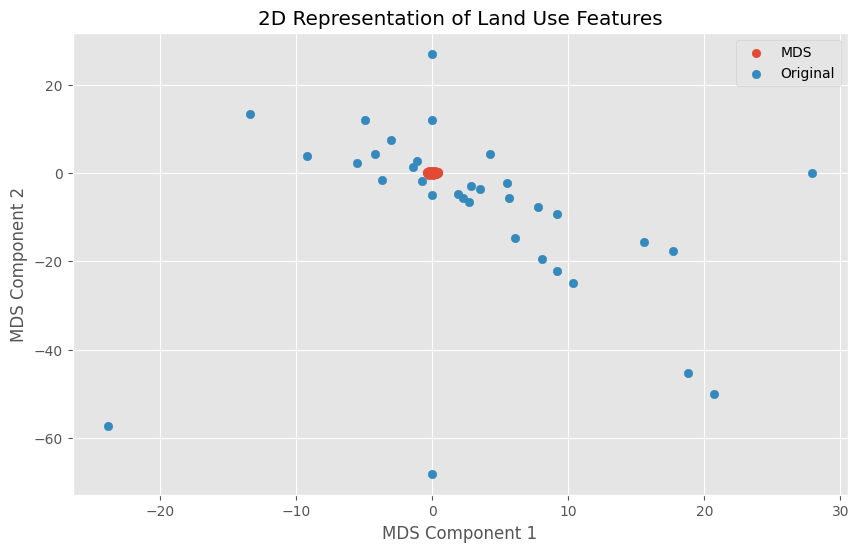

In [50]:
# compare the with the original positions
plt.figure(figsize=(10, 6))
plt.scatter(land_use_2d[:, 0], land_use_2d[:, 1])
plt.scatter(data['cart_x'], data['cart_y'])
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.title('2D Representation of Land Use Features')
plt.legend(['MDS', 'Original'])
plt.show()


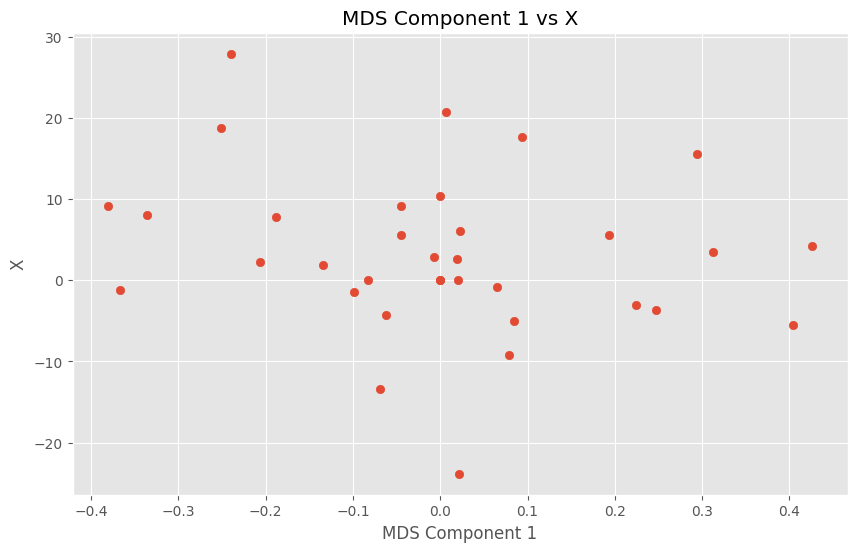

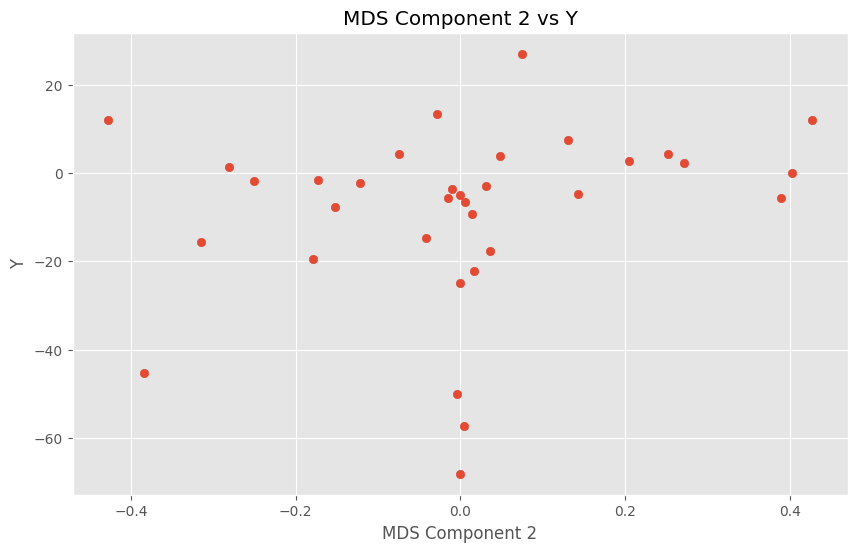

In [51]:
# plot MDS_x vs cart_x
plt.figure(figsize=(10, 6))
plt.scatter(land_use_2d[:, 0], data['cart_x'])
plt.xlabel('MDS Component 1')
plt.ylabel('X')
plt.title('MDS Component 1 vs X')
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(land_use_2d[:, 1], data['cart_y'])
plt.xlabel('MDS Component 2')
plt.ylabel('Y')
plt.title('MDS Component 2 vs Y')
plt.show()

In [52]:
# compute the correlation between the MDS components and the original positions
corr_x=stats.pearsonr(land_use_2d[:, 0], data['cart_x'])
corr_y=stats.pearsonr(land_use_2d[:, 1], data['cart_y'])
print(f'Correlation between MDS Component 1 and X: {corr_x}')
print(f'Correlation between MDS Component 2 and Y: {corr_y}')

Correlation between MDS Component 1 and X: PearsonRResult(statistic=np.float64(-0.2078668235348312), pvalue=np.float64(0.23813368183138203))
Correlation between MDS Component 2 and Y: PearsonRResult(statistic=np.float64(0.20747687880135726), pvalue=np.float64(0.23903512051973752))


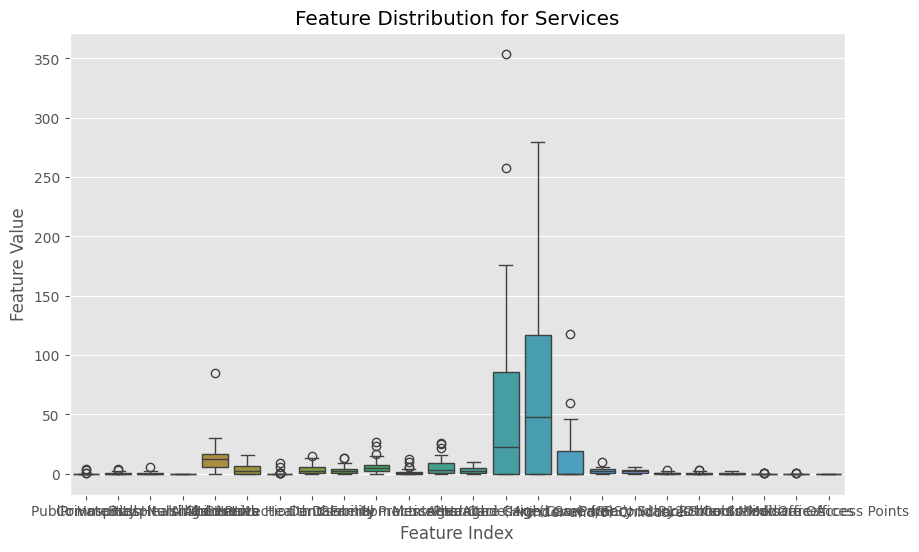

In [53]:
# plot distribution of each of the features of the selected category
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_services)
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title('Feature Distribution for Services')
plt.show()


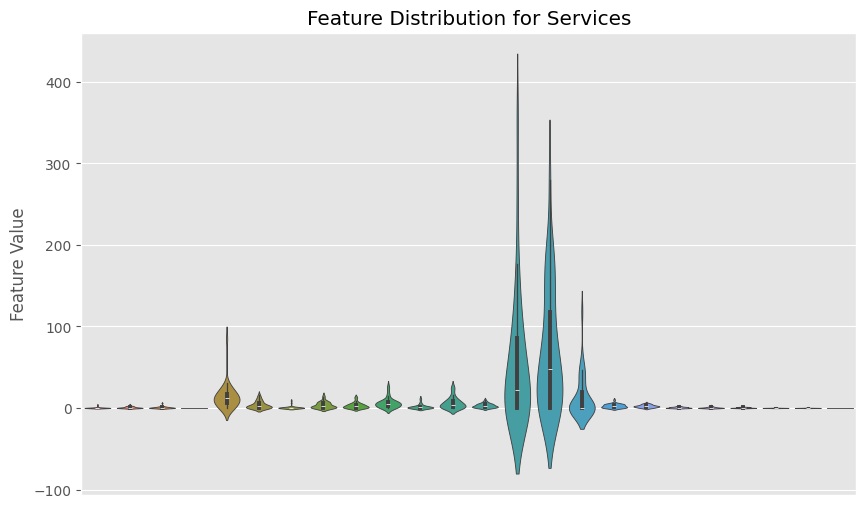

In [54]:

# Plot distribution of each of the features of the selected category without x-axis labels
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_services)
plt.xlabel('')
plt.ylabel('Feature Value')
plt.title('Feature Distribution for Services')
plt.xticks([])  # Hide x-axis labels
plt.show()


In [55]:
# consider the top 5 features
top_features = data_services.sum().sort_values(ascending=False).head(5).index
top_features

Index(['Aged Care (Low Care)', 'Aged Care (High Care)', 'Allied Health',
       'Aged Care (SRS)', 'Mental Health'],
      dtype='object')

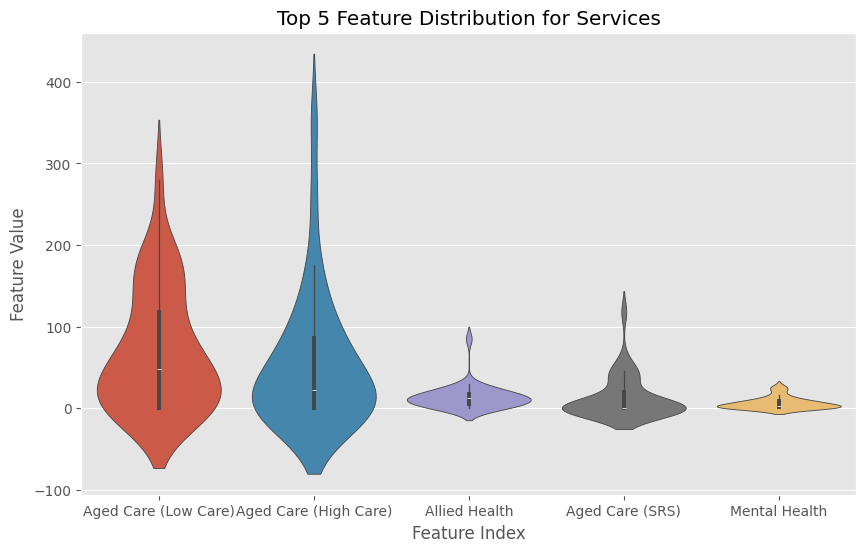

In [56]:
# choose the top 5 features and plot their distribution
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_services[top_features])
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title('Top 5 Feature Distribution for Services')
plt.show()


In [57]:
# compute how much of the variance is explained by the top 5 features
scaler = StandardScaler()
data_services_scaled = scaler.fit_transform(data_services)
pca = PCA(n_components=5)
pca.fit(data_services_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
print('Explained Variance Ratio:', explained_variance_ratio)
print('Total Explained Variance:', sum(explained_variance_ratio))


Explained Variance Ratio: [0.35989618 0.13602978 0.09824901 0.07207123 0.06234183]
Total Explained Variance: 0.7285880233844368


In [58]:
# check how much of the total services is constituted by the top 5

# compute the total services
total_services = data_services.sum().sum()

# compute the total services of the top 5 features
top_services = data_services[top_features].sum().sum()

# compute the percentage of services by the top 5 features
percentage_services = (top_services / total_services) * 100
percentage_services


np.float64(83.81846635367762)

In [59]:
# let's test how about top 2 features
top_features = data_services.sum().sort_values(ascending=False).head(2).index
top_features

Index(['Aged Care (Low Care)', 'Aged Care (High Care)'], dtype='object')

In [61]:
# check how much of the total services is constituted by the top 2

# compute the total services of the top 2 features
top_services = data_services[top_features].sum().sum()

# compute the percentage of services by the top 2 features
percentage_services = (top_services / total_services) * 100
percentage_services

np.float64(66.2754303599374)

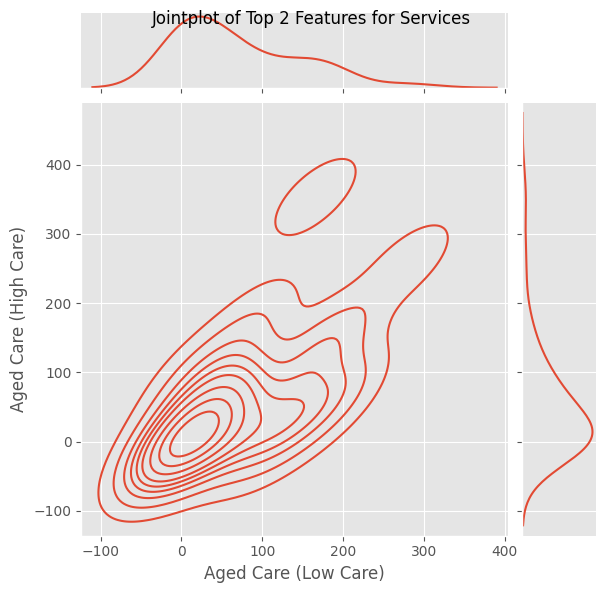

In [64]:
# do a joint plot of the top 2 features
sns.jointplot(x=data_services[top_features[0]], y=data_services[top_features[1]], kind='kde')
plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.suptitle('Jointplot of Top 2 Features for Services')
plt.show()


Correlation between the top 2 features: PearsonRResult(statistic=np.float64(0.6666807845463689), pvalue=np.float64(1.6698680179476915e-05))


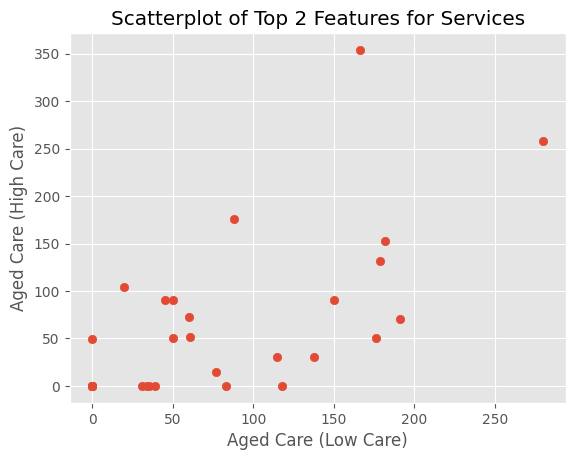

In [68]:
# find out the correlation between the top 2 features
corr = stats.pearsonr(data_services[top_features[0]], data_services[top_features[1]])
print('Correlation between the top 2 features:', corr)
plt.scatter(data_services[top_features[0]], data_services[top_features[1]])
plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.title('Scatterplot of Top 2 Features for Services')
plt.show()

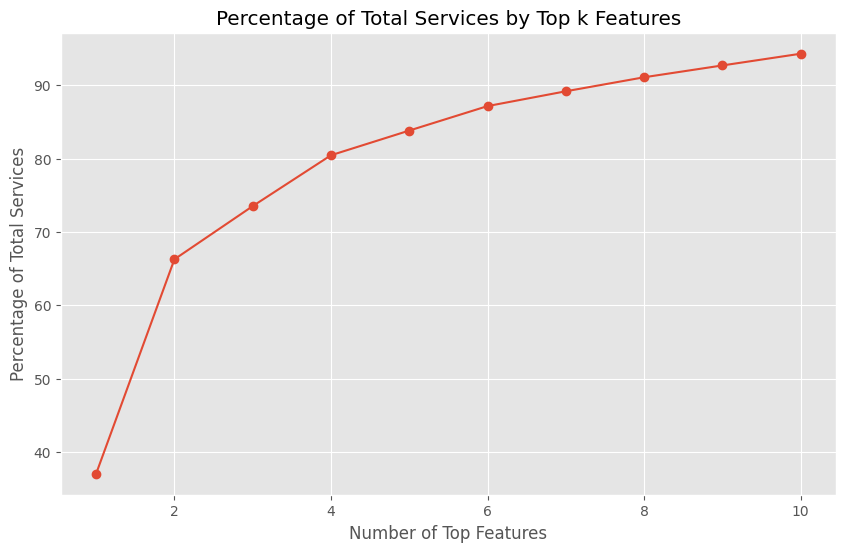

In [70]:
# plot the curve of % taken by top k features
percentage_services = []
for k in range(1, 11):
	top_features = data_services.sum().sort_values(ascending=False).head(k).index
	top_services = data_services[top_features].sum().sum()
	percentage_services.append((top_services / total_services) * 100)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), percentage_services, marker='o')
plt.xlabel('Number of Top Features')
plt.ylabel('Percentage of Total Services')
plt.title('Percentage of Total Services by Top k Features')
plt.show()

<Figure size 1000x600 with 0 Axes>

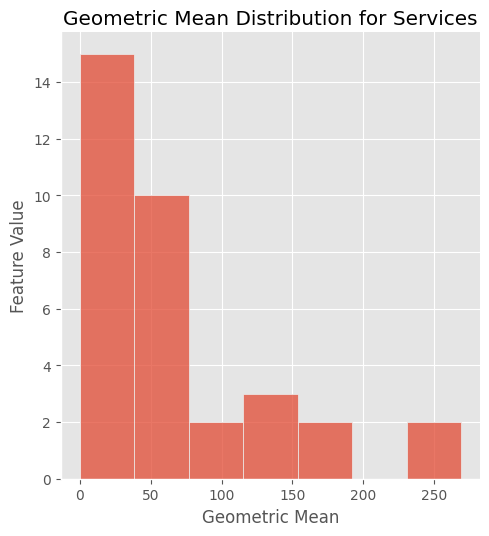

In [93]:
# take the geometric mean of the top 2 features
top_features = data_services.sum().sort_values(ascending=False).head(2).index
geo_mean=(data_services[top_features[0]] +data_services[top_features[1]])/2

# plot the distribution of the geometric mean
plt.figure(figsize=(10, 6))
sns.displot(data=geo_mean)
plt.xlabel('Geometric Mean')
plt.ylabel('Feature Value')
plt.title('Geometric Mean Distribution for Services')
plt.show()

In [31]:
# compute the Moran's I for the geometric mean
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))
w = ps.weights.KNN.from_dataframe(gdf, k=2)
moran = Moran(sum_services, w)
print('Moran\'s I:', moran.I)
print('Moran\'s Expected I:', moran.EI)
print('Moran\'s I p-value:', moran.p_sim)


Moran's I: -0.0312113979606866
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.499


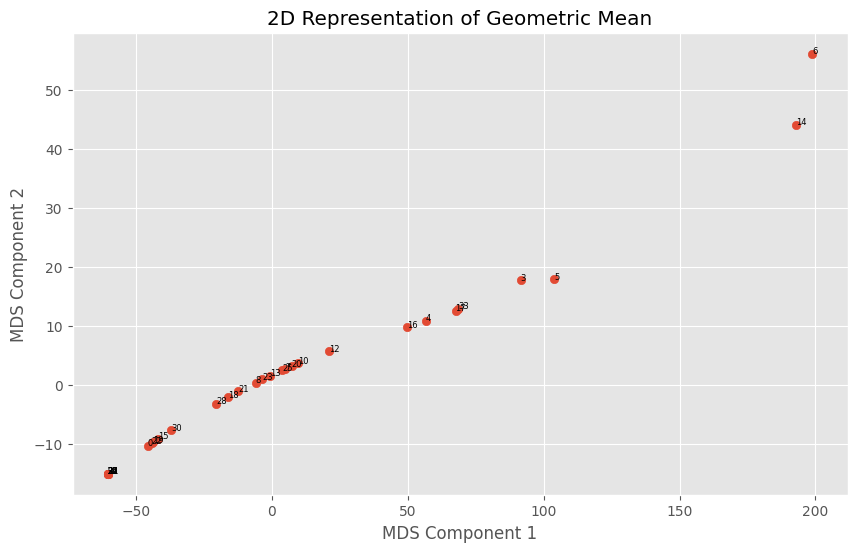

In [95]:
# compute distance matrix in terms of the geometric mean
z=geo_mean.values
# distance in terms in pairwise absolute differences of z
distance_matrix = [[np.abs(z[i] - z[j]) for j in range(len(z))] for i in range(len(z))]
# initialize the MDS model
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=42)
# fit the MDS model
land_use_2d = mds.fit_transform(distance_matrix)
# plot the 2D representation of the Land Use features
plt.figure(figsize=(10, 6))
plt.scatter(land_use_2d[:, 0], land_use_2d[:, 1])
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.title('2D Representation of Geometric Mean')
# annotate the points with the suburb index
for i in range(len(land_use_2d)):
	plt.text(land_use_2d[i, 0], land_use_2d[i, 1], i, fontsize=6)

plt.show()

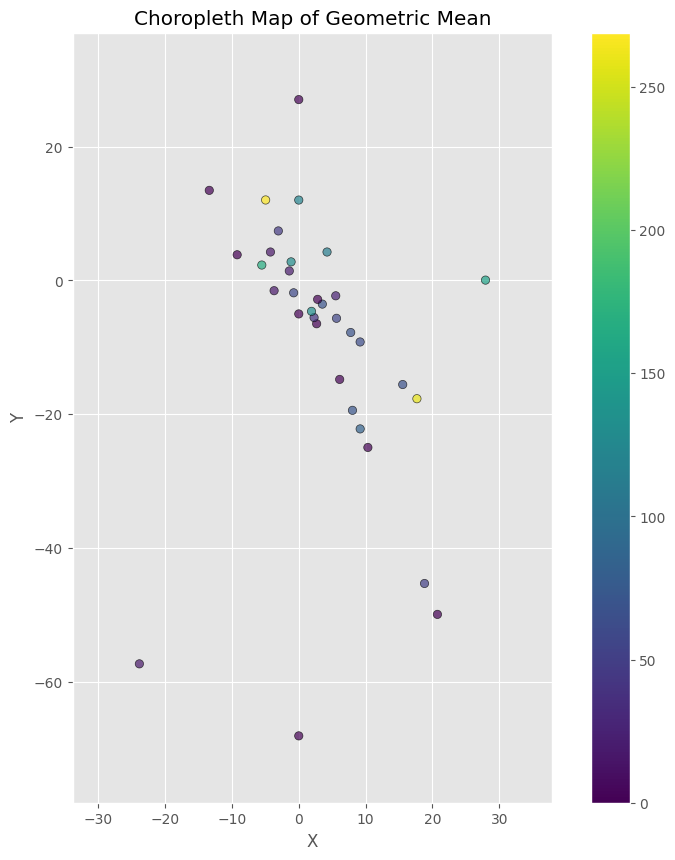

In [96]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a DataFrame with the geometric mean and the positions
df = pd.DataFrame({
    'geo_mean': geo_mean,
    'X': data['cart_x'],
    'Y': data['cart_y']
})

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['X'], df['Y']))

# Set the aspect ratio and extent for better shape representation
minx, miny, maxx, maxy = gdf.total_bounds
plt.figure(figsize=(10, 10))
ax = plt.gca()

# Plot the choropleth map with boundaries for better shape
gdf.plot(column='geo_mean', cmap='viridis', legend=True, ax=ax, alpha=0.7, edgecolor='black')

# Set the limits of the plot to match the data extent
ax.set_xlim(minx-10, maxx+10)
ax.set_ylim(miny-10, maxy+10)

# Add labels and title for clarity
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Choropleth Map of Geometric Mean')
plt.grid(True)
plt.show()


In [32]:
fcmap['Services']

['Public Hospitals',
 'Private Hospitals',
 'Community Health Centres',
 'Bush Nursing Centres',
 'Allied Health',
 'Alternative Health',
 'Child Protection and Family',
 'Dental',
 'Disability',
 'General Practice',
 'Homelessness',
 'Mental Health',
 'Pharmacies',
 'Aged Care (High Care)',
 'Aged Care (Low Care)',
 'Aged Care (SRS)',
 'Kinder and/or Childcare',
 'Primary Schools',
 'Secondary Schools',
 'P12 Schools',
 'Other Schools',
 'Centrelink Offices',
 'Medicare Offices',
 'Medicare Access Points']

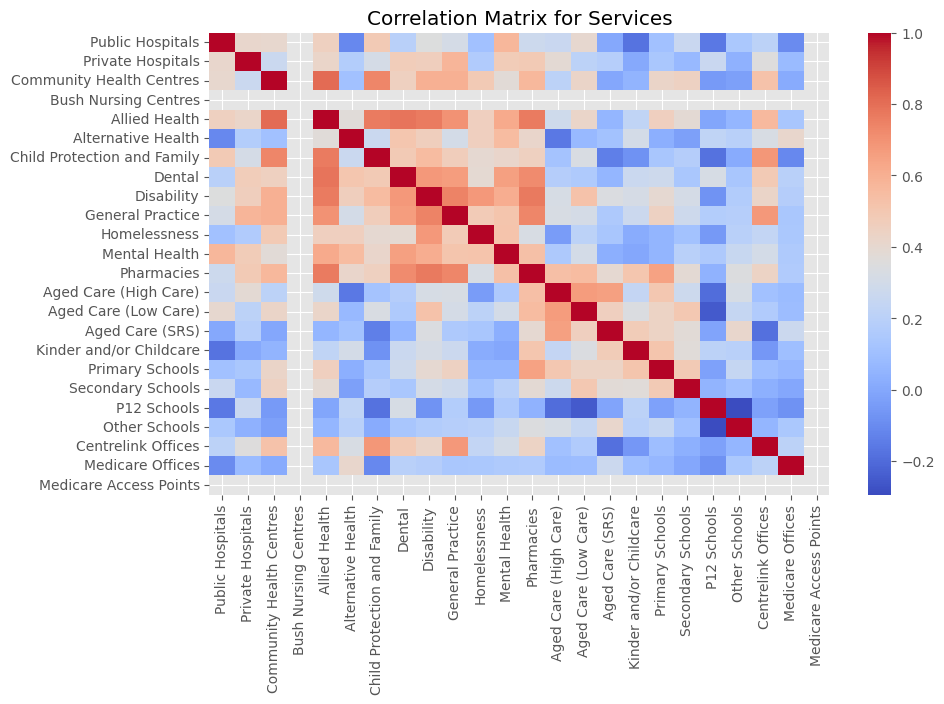

In [35]:
# compute correlation matrix out of data_services
corr_mat_feat=data_services.corr()
# plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat_feat, cmap='coolwarm')
plt.title('Correlation Matrix for Services')
plt.show()



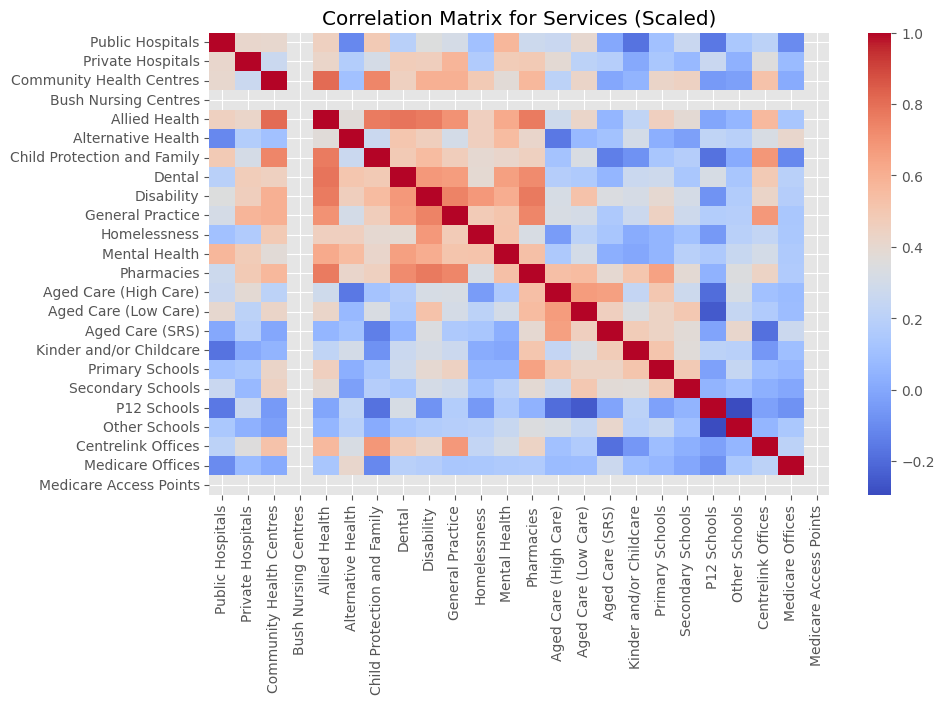

In [46]:
# scale the data_services between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_services_scaled = scaler.fit_transform(data_services)
# create a DataFrame
data_services_scaled = pd.DataFrame(data_services_scaled, columns=data_services.columns)
# compute the correlation matrix
corr_mat_feat_scaled = data_services_scaled.corr()
# plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat_feat_scaled, cmap='coolwarm')
plt.title('Correlation Matrix for Services (Scaled)')
plt.show()


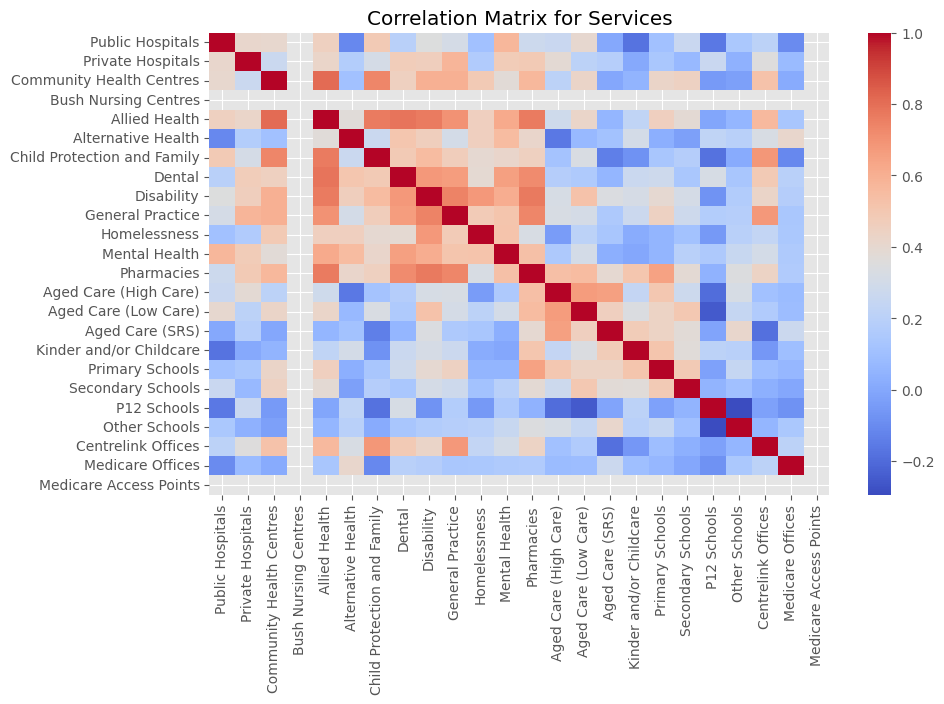

In [47]:
# compute the correlation matrix for the scaled data
corr_mat_feat_scaled=data_services_scaled.corr()
# plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat_feat_scaled, cmap='coolwarm')
plt.title('Correlation Matrix for Services')
plt.show()

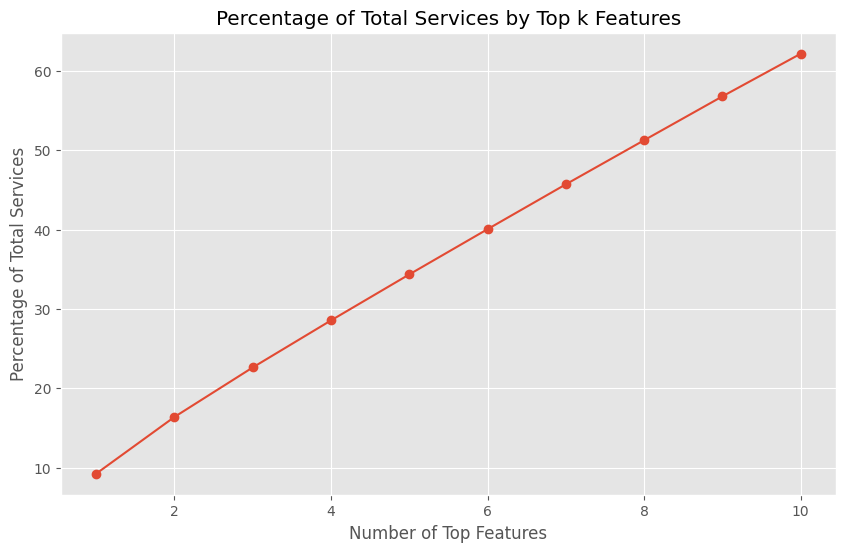

In [48]:
# take the k dominant features and plot 
total_services = data_services_scaled.sum().sum()
percentage_services = []
for k in range(1, 11):
	top_features = data_services_scaled.sum().sort_values(ascending=False).head(k).index
	top_services = data_services_scaled[top_features].sum().sum()
	percentage_services.append((top_services / total_services) * 100)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), percentage_services, marker='o')
plt.xlabel('Number of Top Features')
plt.ylabel('Percentage of Total Services')
plt.title('Percentage of Total Services by Top k Features')
plt.show()


In [60]:
# do a PCA on the scaled data
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pca.fit(data_services_scaled)
data_services_pca = pca.transform(data_services_scaled)
data_services_pca, pca.explained_variance_ratio_

(array([[-2.79412863e-01,  1.20705993e-01,  3.62817379e-02,
         -1.92248661e-01,  5.42373620e-02,  1.67432245e-02,
         -3.54078716e-01,  2.25148610e-02, -6.57785313e-03,
         -1.03778834e-01,  2.31108015e-01,  2.13940653e-01,
         -6.27816967e-02,  3.81679293e-02,  2.69141964e-01],
        [-3.66778840e-01,  2.00685910e-01, -1.75228746e-01,
         -5.77375902e-02,  1.29039629e-02, -2.05021177e-01,
         -1.16750920e-01,  4.25459889e-01, -2.77153389e-01,
          9.71017002e-02,  1.27229020e-01, -1.77864623e-01,
         -1.39463574e-01, -1.45593426e-01,  4.13215861e-02],
        [-2.58059660e-01,  1.83862019e-01, -6.89955295e-02,
          4.33442483e-01,  2.27386859e-01, -1.40003498e-01,
         -1.83373616e-02,  1.82053373e-01, -4.01288243e-01,
         -2.61389120e-01,  7.02855443e-02,  3.60820551e-01,
          5.50984331e-02,  9.54198452e-02, -1.80456900e-01],
        [ 8.16203198e-01,  7.04214647e-01,  3.81909148e-01,
          2.58501395e-01,  1.44677118

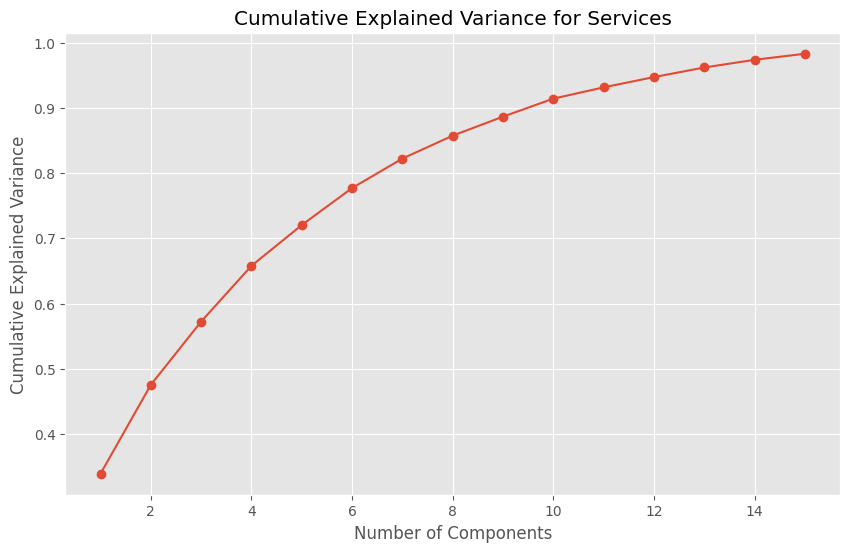

array([0.33889266, 0.47526728, 0.57235705, 0.65791027, 0.72048724,
       0.77724439, 0.82247681, 0.8576423 , 0.88683566, 0.91442774,
       0.93173531, 0.94752193, 0.96220634, 0.97400517, 0.98331618])

In [64]:
# compute cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance for Services')
plt.show()
cumulative_variance

In [65]:
data_services_scaled


,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0.00,0.25,0.166667,0.0,0.117647,0.3125,0.000000,0.000000,0.000000,0.074074,...,0.110714,0.000000,0.4,0.500000,0.000000,0.000000,0.5,0.0,0.0,0.0
1,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.000000,0.066667,0.076923,0.148148,...,0.000000,0.000000,0.1,0.333333,0.666667,0.000000,0.5,0.0,0.0,0.0
2,0.25,0.00,0.166667,0.0,0.176471,0.0000,0.000000,0.066667,0.076923,0.296296,...,0.000000,0.000000,0.2,1.000000,0.333333,0.333333,0.0,0.0,0.0,0.0
3,0.00,0.25,0.000000,0.0,0.352941,0.5000,0.000000,0.466667,0.692308,0.333333,...,0.639286,0.381356,1.0,0.833333,0.666667,0.000000,0.0,0.0,0.0,0.0
4,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.000000,0.066667,0.000000,0.185185,...,0.535714,0.000000,0.3,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.0
5,0.75,0.75,1.000000,0.0,1.000000,0.2500,1.000000,1.000000,1.000000,0.851852,...,0.650000,0.000000,0.2,0.833333,0.666667,0.000000,0.0,1.0,0.0,0.0
6,0.00,0.00,0.333333,0.0,0.200000,0.0000,0.000000,0.133333,0.230769,0.259259,...,1.000000,0.305085,0.4,0.833333,0.333333,0.000000,0.5,0.0,0.0,0.0
7,0.00,0.25,0.000000,0.0,0.152941,0.6875,0.000000,0.333333,0.307692,0.185185,...,0.160714,0.389831,0.6,0.666667,0.000000,0.000000,0.5,0.0,1.0,0.0
8,0.00,1.00,0.000000,0.0,0.141176,0.4375,0.000000,0.533333,0.307692,0.222222,...,0.217857,0.000000,0.0,0.333333,0.000000,0.666667,0.0,0.0,0.0,0.0
9,0.00,0.00,0.000000,0.0,0.011765,0.0000,0.000000,0.000000,0.000000,0.037037,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [50]:
# compute variance of the hospital services
variance_services = data_services_scaled.var()
variance_services

Public Hospitals               0.046624
Private Hospitals              0.069352
Community Health Centres       0.037062
Bush Nursing Centres           0.000000
Allied Health                  0.031297
Alternative Health             0.078783
Child Protection and Family    0.041163
Dental                         0.068449
Disability                     0.070463
General Practice               0.053565
Homelessness                   0.056620
Mental Health                  0.076719
Pharmacies                     0.064242
Aged Care (High Care)          0.052905
Aged Care (Low Care)           0.070546
Aged Care (SRS)                0.048264
Kinder and/or Childcare        0.053948
Primary Schools                0.076971
Secondary Schools              0.072193
P12 Schools                    0.088829
Other Schools                  0.077540
Centrelink Offices             0.106952
Medicare Offices               0.082888
Medicare Access Points         0.000000
dtype: float64

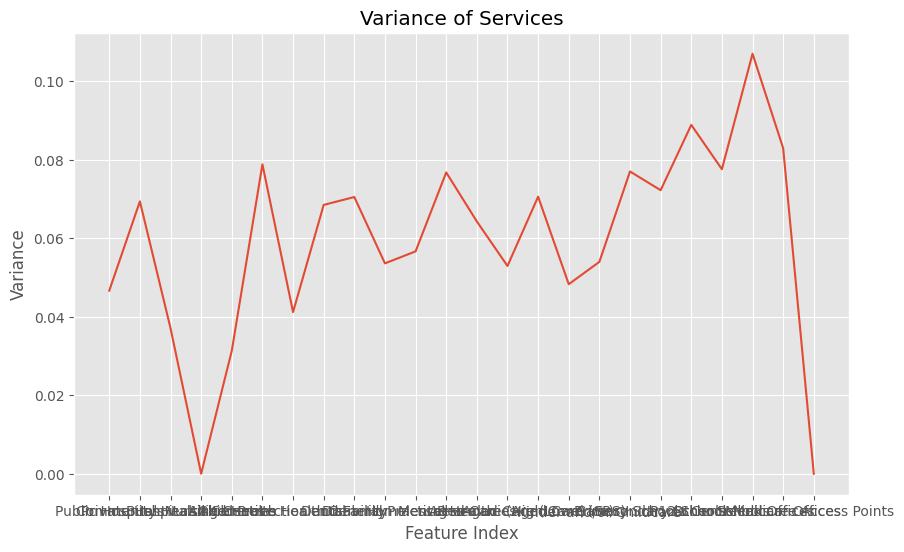

In [51]:
# plot the variance of the services
plt.figure(figsize=(10, 6))
plt.plot(variance_services)
plt.xlabel('Feature Index')
plt.ylabel('Variance')
plt.title('Variance of Services')
plt.show()

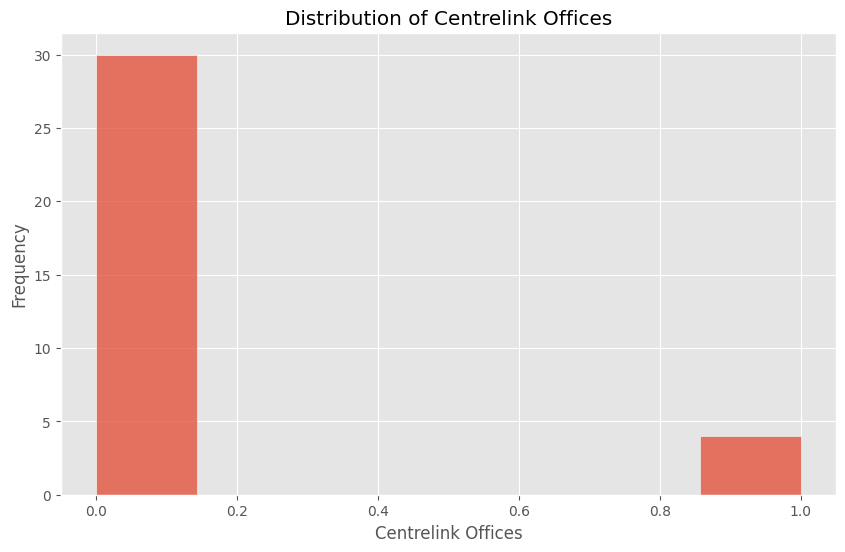

In [52]:
# distribution of cenrelink offices
plt.figure(figsize=(10, 6))
sns.histplot(data['Centrelink Offices'])
plt.xlabel('Centrelink Offices')
plt.ylabel('Frequency')
plt.title('Distribution of Centrelink Offices')
plt.show()

In [54]:
data['Centrelink Offices']

0     0
1     0
2     0
3     0
4     0
5     1
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    1
21    0
22    0
23    1
24    0
25    1
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
Name: Centrelink Offices, dtype: int64

In [67]:
# do a factor analysis on the scaled data
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=1)
fa.fit(data_services_scaled)
data_services_fa = fa.transform(data_services_scaled)
data_services_fa


array([[-0.37951241],
       [-0.40468945],
       [-0.23609218],
       [ 1.17739643],
       [-0.29654958],
       [ 3.94947161],
       [ 0.3824303 ],
       [ 0.20937492],
       [ 0.24509637],
       [-1.07733999],
       [-0.20590091],
       [-0.21127415],
       [-0.43097233],
       [-0.71401793],
       [ 0.67228107],
       [ 0.14242182],
       [ 0.80027464],
       [ 0.06837913],
       [-0.86752364],
       [-0.4211574 ],
       [ 0.65148619],
       [-0.66967866],
       [-0.93767885],
       [ 0.73233726],
       [ 0.43571487],
       [ 1.09941777],
       [-1.1128997 ],
       [-0.49008843],
       [ 1.34606615],
       [-1.1128997 ],
       [ 0.27406875],
       [-0.99213678],
       [-1.1128997 ],
       [-0.51290546]])

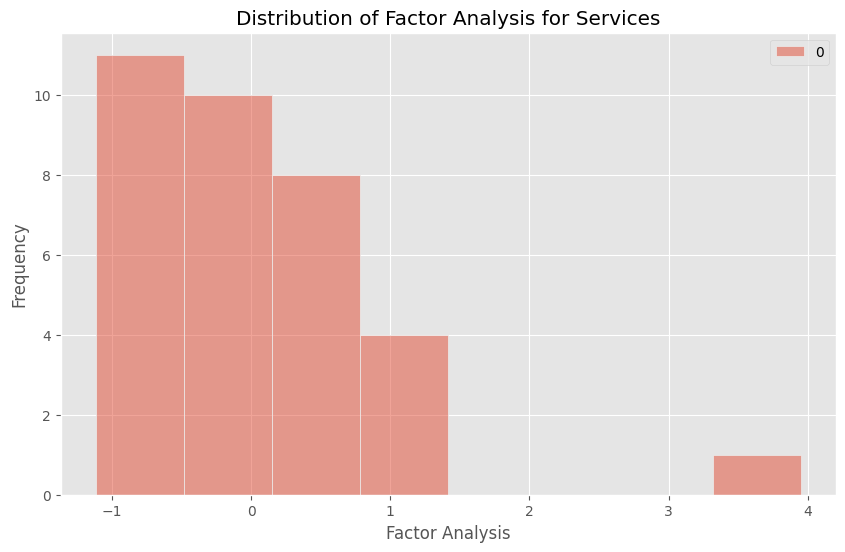

In [68]:
# plot the factor analysis
plt.figure(figsize=(10, 6))
sns.histplot(data_services_fa)
plt.xlabel('Factor Analysis')
plt.ylabel('Frequency')
plt.title('Distribution of Factor Analysis for Services')
plt.show()

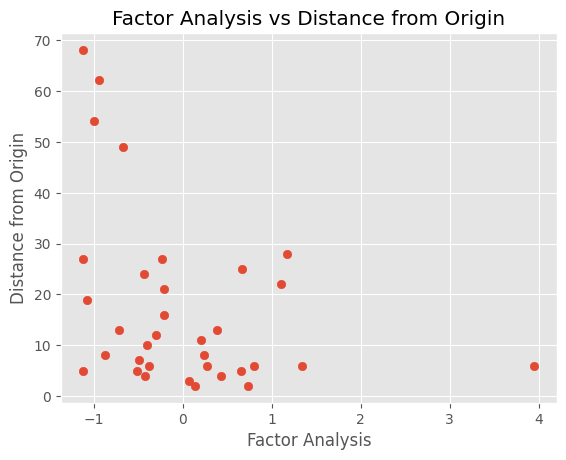

PearsonRResult(statistic=np.float64(-0.3635848695714195), pvalue=np.float64(0.034541638493183556))

In [71]:
# compute the correlation between the factor analysis and the distance from the origin
distance_from_origin = np.linalg.norm(suburb_locs, axis=1)
corr = stats.pearsonr(data_services_fa[:, 0], distance_from_origin)
plt.scatter(data_services_fa[:, 0], distance_from_origin)
plt.xlabel('Factor Analysis')
plt.ylabel('Distance from Origin')
plt.title('Factor Analysis vs Distance from Origin')
plt.show()
corr